In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy
from scipy.interpolate import interp1d
import csv
import os
from sipm.analysis.SipmCalibration import SipmCalibration
import yaml

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd


/home/as111/sipm-analysis


## Example waveforms

/scratch/gpfs/GALBIATI/data/sipm//hamamatsu_test/2023-07-27/2023-07-27_volt_90_light_laser_config_2_cond_ln_intensity_800/1/wave0.dat
20670 events


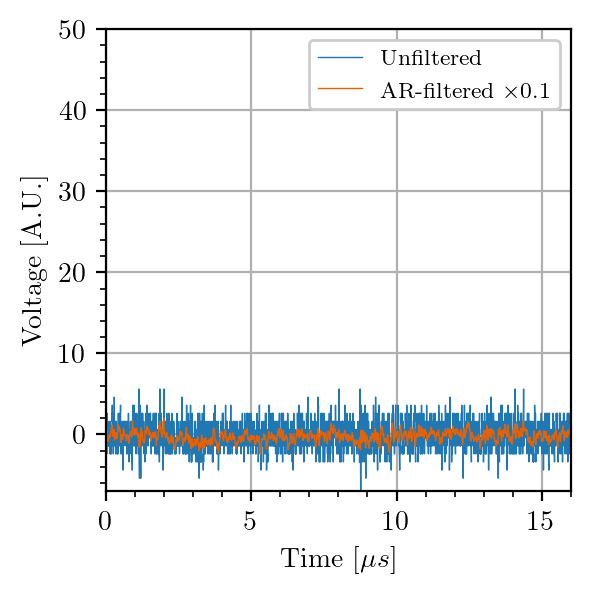

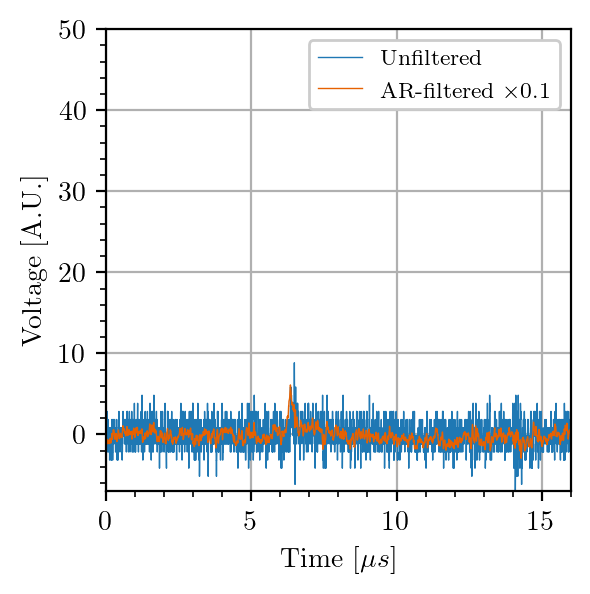

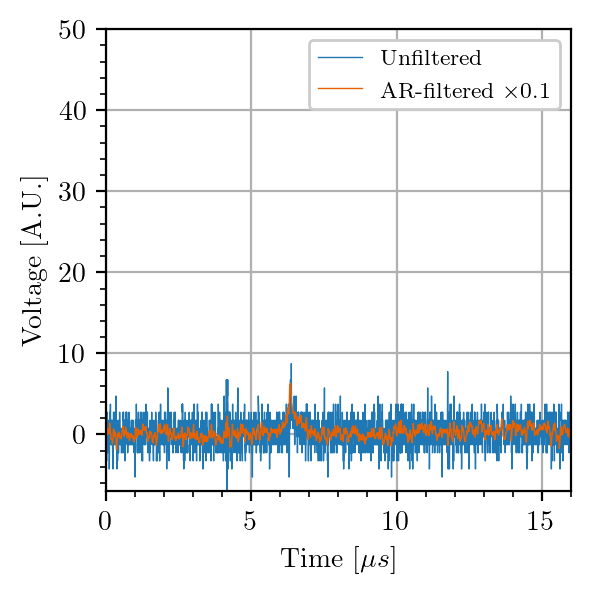

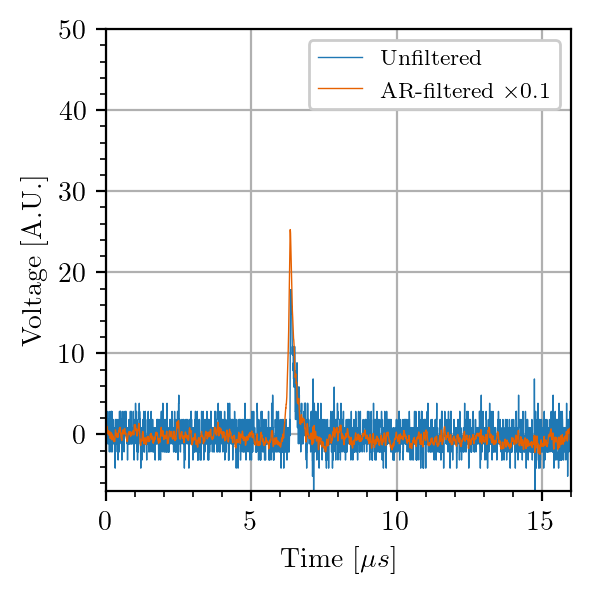

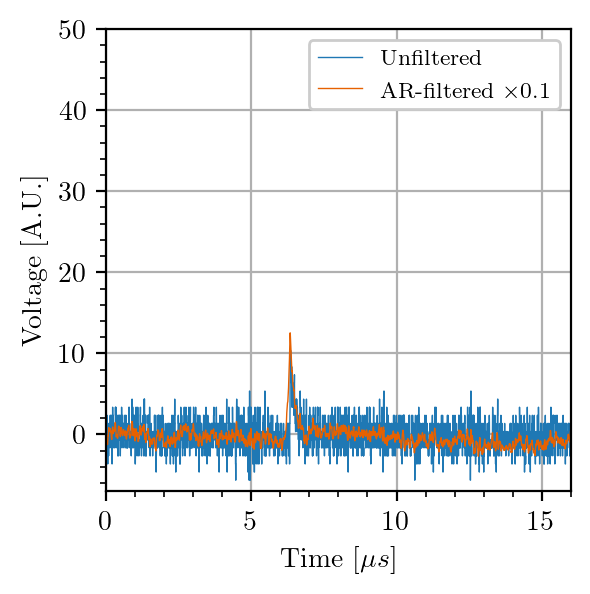

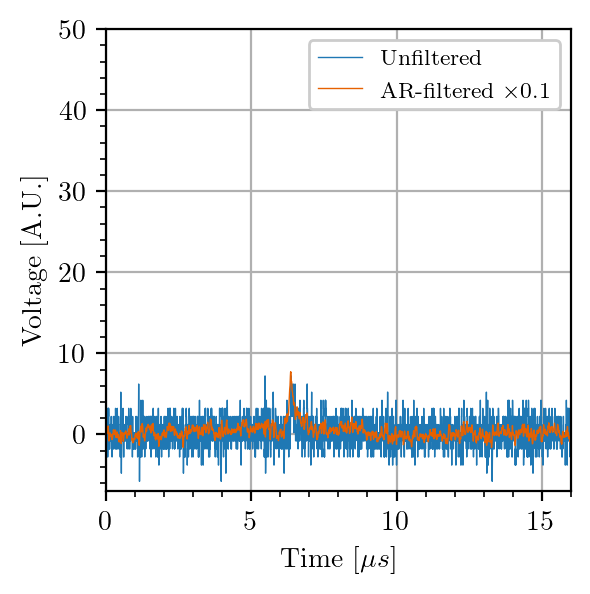

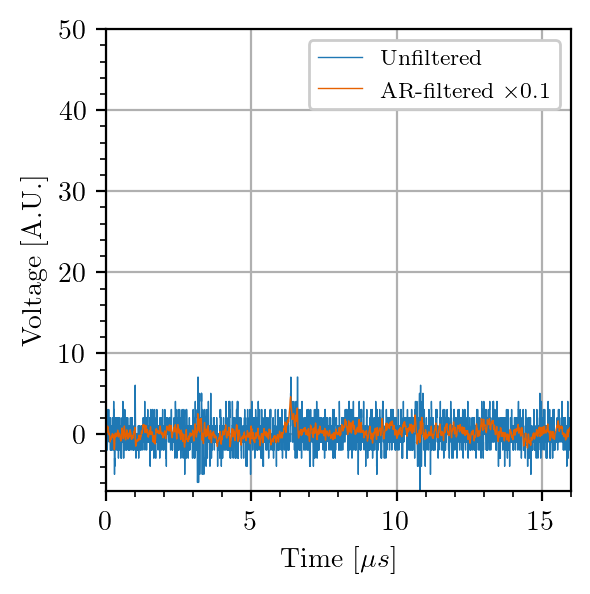

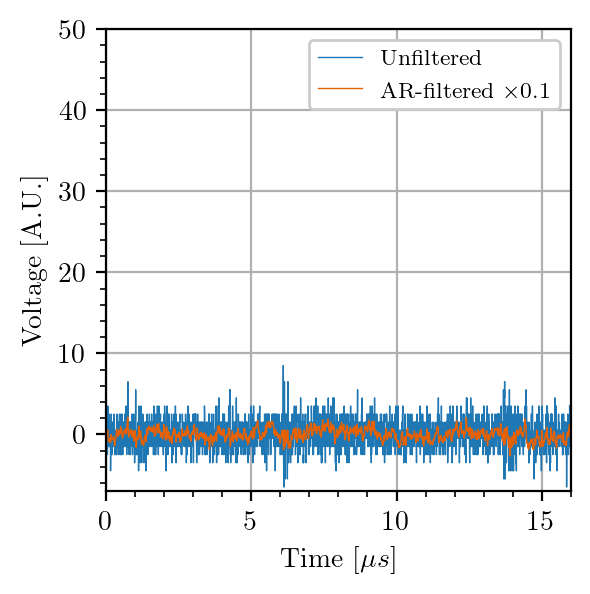

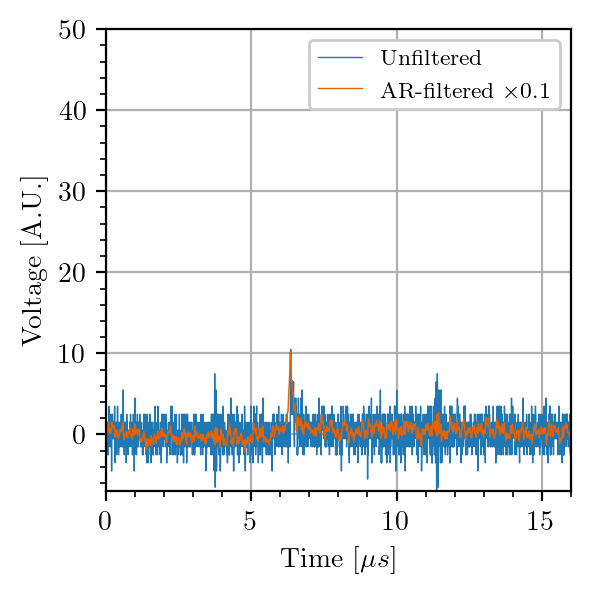

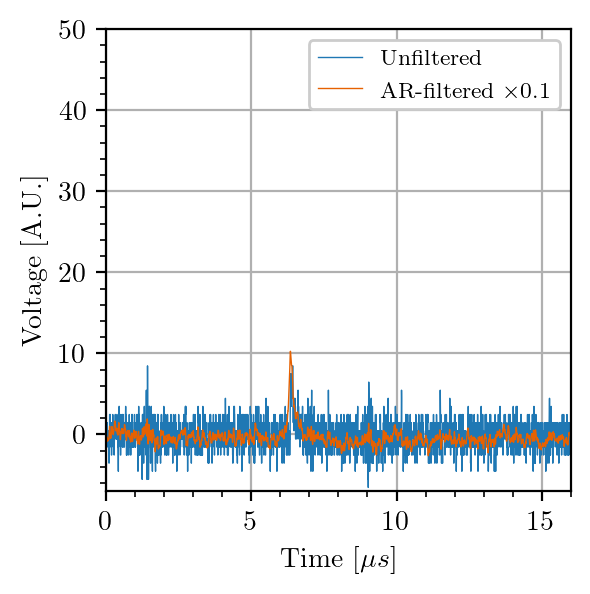

In [4]:
import sipm.recon.WaveformDataset as wfd
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/'
direc = '2023-07-27/2023-07-27_volt_90_light_laser_config_2_cond_ln_intensity_800/1/'
ch = 0
evid = np.arange(0, 10)
dset = wfd.WaveformDataset(path='{}{}'.format(
    data_dir, direc), pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i, wf in enumerate(wfs):
    plt.figure(i, figsize=(3, 3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1,
             label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-7, 50)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [48]:
voltages = [90,92,94,96,98]
channels = [0,1,2,3]
directory = '/scratch/gpfs/as111/results/'
date = '2023-07-27'
verbose = True
intn = 800
metadata_dict = {}
for ch in channels:
    metadata_dict[ch] = {}
    for volt in voltages:
        metadata_dict[ch][volt] = {'metadata':{
            'date':'2023-07-27',
            'volt': volt,
            'light': 'laser',
            'cond': f'ln_intensity_{intn}',
            'config': 2,
            'intensity': intn,
            'run': '*',
            'ch': ch
        }}
        files = glob.glob(f"{directory}{date}/{date}_volt_{volt}_light_laser_cond_ln_intensity_{intn}_config_2_intensity_{intn}_run*_laser_pulse.h5")
        data = []
        for f in files:
            ind = f.find('run')+3
            run_number = int(f[ind:f.find('_',ind)])
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            df['event'] = df.index
            df['run'] = np.array([run_number]*df.shape[0])
            data.append(df)
        if len(files)>0:
            data = pd.concat(data, ignore_index=True).sort_values(by=['run','event']).reset_index(drop=True)
        metadata_dict[ch][volt]['data'] = data
        if verbose:
            if len(files)==0:
                events = 0
            else:
                keys = data.keys()
                events = len(data[keys[0]])
            print(f'{date} {volt}V ch{ch} - {len(files)} files {events} events')

2023-07-27 90V ch0 - 5 files 103570 events
2023-07-27 92V ch0 - 5 files 104549 events
2023-07-27 94V ch0 - 5 files 104770 events
2023-07-27 96V ch0 - 5 files 103880 events
2023-07-27 98V ch0 - 5 files 103776 events
2023-07-27 90V ch1 - 5 files 103570 events
2023-07-27 92V ch1 - 5 files 104549 events
2023-07-27 94V ch1 - 5 files 104770 events
2023-07-27 96V ch1 - 5 files 103880 events
2023-07-27 98V ch1 - 5 files 103776 events
2023-07-27 90V ch2 - 5 files 103570 events
2023-07-27 92V ch2 - 5 files 104549 events
2023-07-27 94V ch2 - 5 files 104770 events
2023-07-27 96V ch2 - 5 files 103880 events
2023-07-27 98V ch2 - 5 files 103776 events
2023-07-27 90V ch3 - 5 files 103570 events
2023-07-27 92V ch3 - 5 files 104549 events
2023-07-27 94V ch3 - 5 files 104770 events
2023-07-27 96V ch3 - 5 files 103880 events
2023-07-27 98V ch3 - 5 files 103776 events


## Baseline quality cut
To avoid pre-trigger pulses or abnormal fluctuations, we require that the RMS variation in the baseline region ($t<t_{\rm trigger}-0.5~\rm\mu s$) be less than $2.5$ ADC units.
This baseline cut normalizes the baseline mean distribution.
Cut fraction is around $0.1\%$ ($2\%$) for the top (bottom) tile.

In [49]:
verbose = True
thre_ch = [1.9,1.5,1.7,1.5]
mybsl = {}
for ch in channels:
    mybsl[ch] = {}
    for volt in voltages:
        mybsl[ch][volt] = {'rms_threshold': thre_ch[ch]}
        data = metadata_dict[ch][volt]['data']
        data['bsl_cut'] = data['baseline_rms']<mybsl[ch][volt]['rms_threshold']
        rms_hist, rms_bins = np.histogram(data['baseline_rms'], bins=500, range=(0, 8))
        mean_hist, mean_bins = np.histogram(data['baseline_mean'], bins=1500, range=(3810, 3870))
        mean_hist_cut, mean_bins_cut = np.histogram(data['baseline_mean'].loc[data['bsl_cut']], bins=1500, range=(3800, 3900))
        cut_fraction = 1-np.sum(data['bsl_cut'])/data.shape[0]
        mybsl[ch][volt].update({
            'rms_hist':rms_hist, 'rms_bins':rms_bins,
            'mean_hist':mean_hist, 'mean_bins':mean_bins,
            'mean_hist_cut':mean_hist_cut, 'mean_bins_cut':mean_bins_cut,
            'cut_fraction':cut_fraction
        })
        if verbose:
            print(f'{volt}V ch{ch} cut fraction = {cut_fraction*100:.5f}%')
            

90V ch0 cut fraction = 0.15448%
92V ch0 cut fraction = 2.86277%
94V ch0 cut fraction = 2.90446%
96V ch0 cut fraction = 3.14883%
98V ch0 cut fraction = 3.01515%
90V ch1 cut fraction = 1.01091%
92V ch1 cut fraction = 2.83121%
94V ch1 cut fraction = 3.33779%
96V ch1 cut fraction = 3.54640%
98V ch1 cut fraction = 3.00262%
90V ch2 cut fraction = 0.00000%
92V ch2 cut fraction = 0.81875%
94V ch2 cut fraction = 1.77341%
96V ch2 cut fraction = 2.04563%
98V ch2 cut fraction = 1.78365%
90V ch3 cut fraction = 0.49049%
92V ch3 cut fraction = 1.75133%
94V ch3 cut fraction = 2.07311%
96V ch3 cut fraction = 2.04948%
98V ch3 cut fraction = 1.90699%


Text(0.07, 0.5, 'Count')

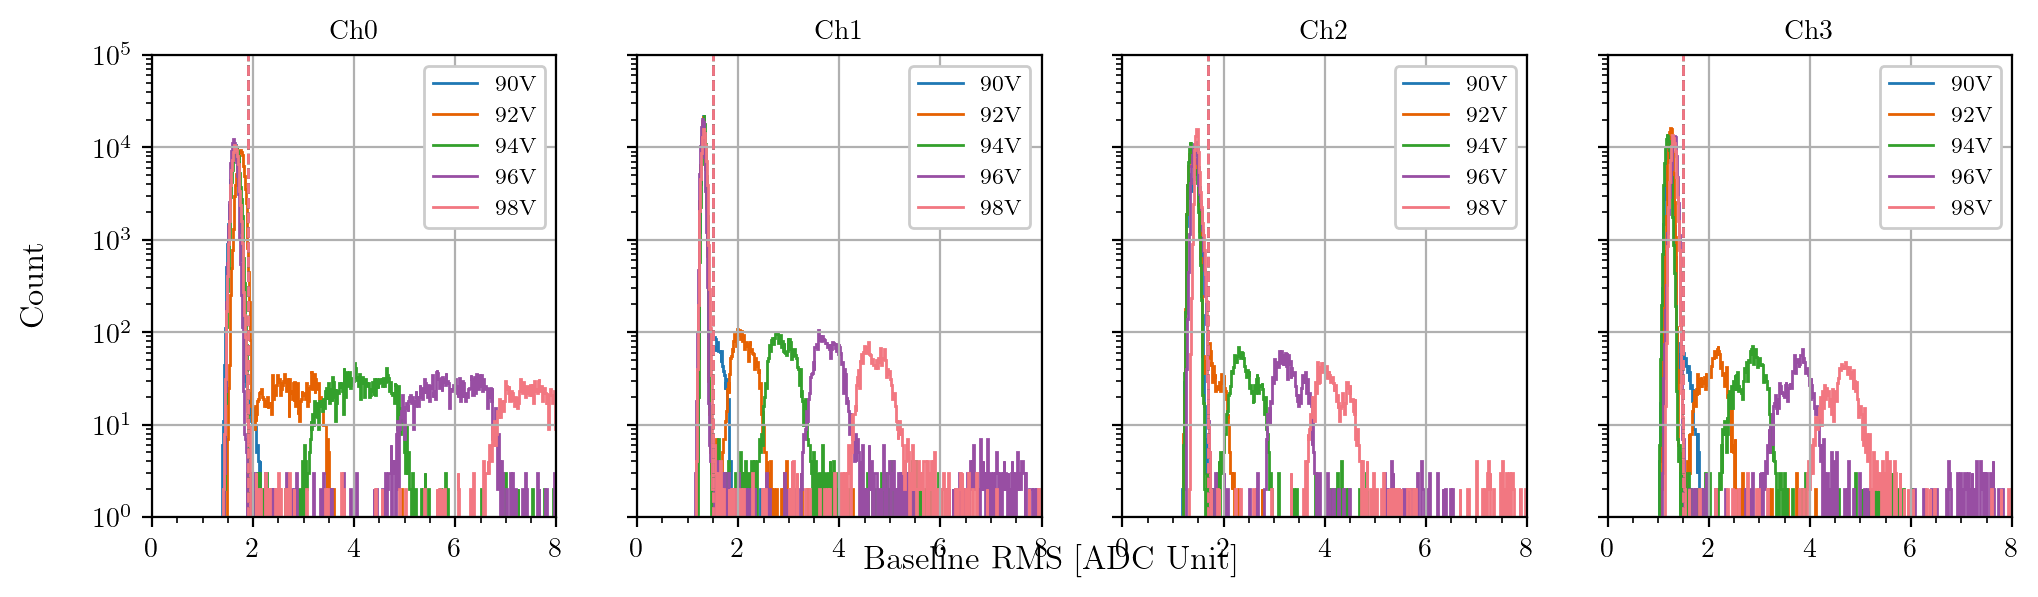

In [50]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        axs[j].stairs(mybsl[ch][volt]['rms_hist'],
                            mybsl[ch][volt]['rms_bins'],
                            label=f'{volt}V', color=f'C{k}')
        th = mybsl[ch][volt]['rms_threshold']
        axs[j].plot([th, th], [1, 1e5], f'C{k}--', linewidth=1)
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1, 1e5)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Ch{ch}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

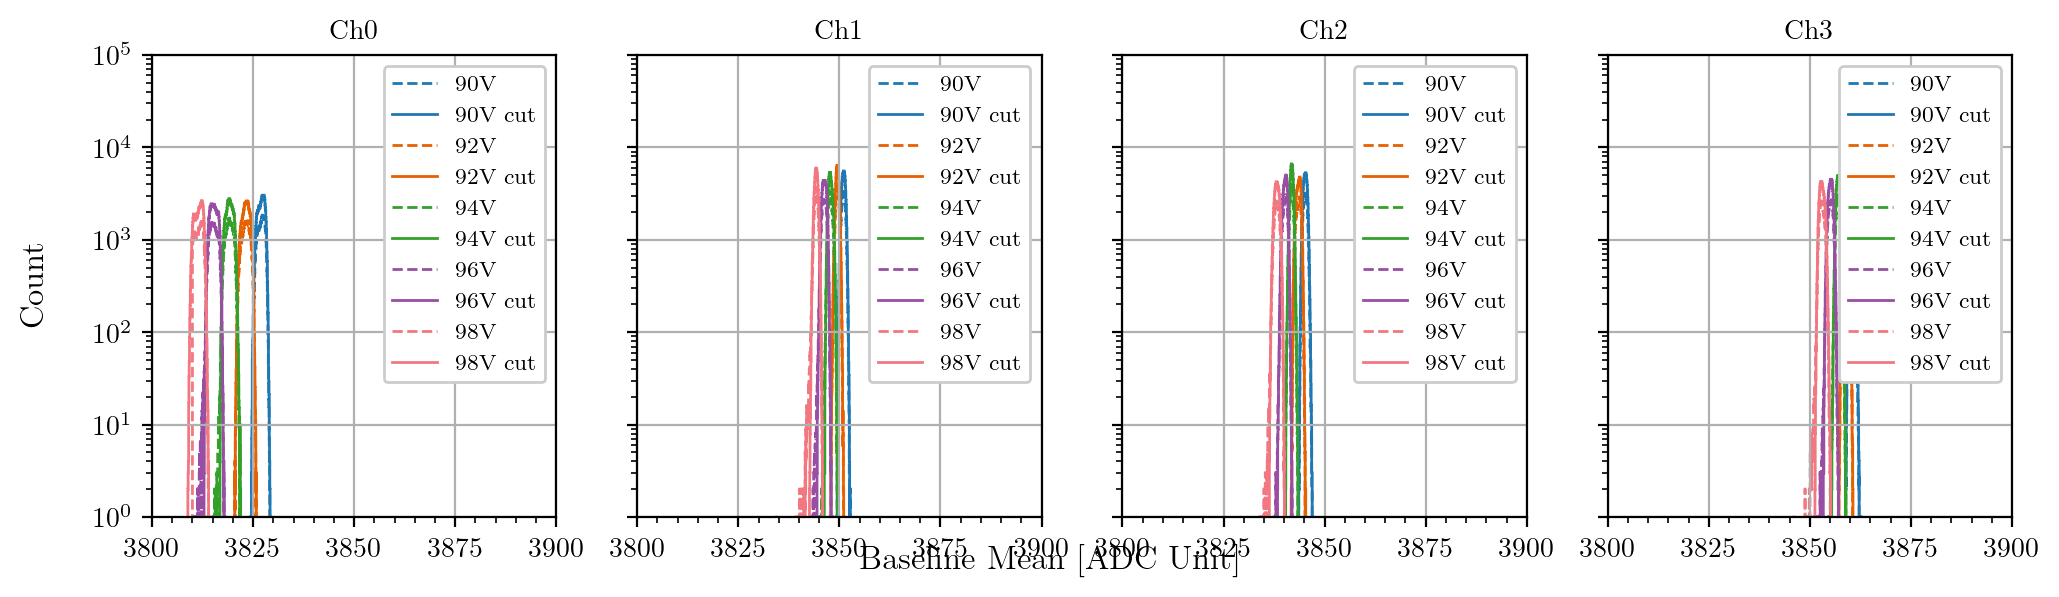

In [51]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        axs[j].stairs(mybsl[ch][volt]['mean_hist'],
                mybsl[ch][volt]['mean_bins'],
                label=f'{volt}V', color=f'C{k}', linestyle='--')
        axs[j].stairs(mybsl[ch][volt]['mean_hist_cut'],
                            mybsl[ch][volt]['mean_bins_cut'],
                            label=f'{volt}V cut', color=f'C{k}')
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1, 1e5)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Ch{ch}')
fig.supxlabel('Baseline Mean [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Plots for ch3 90V


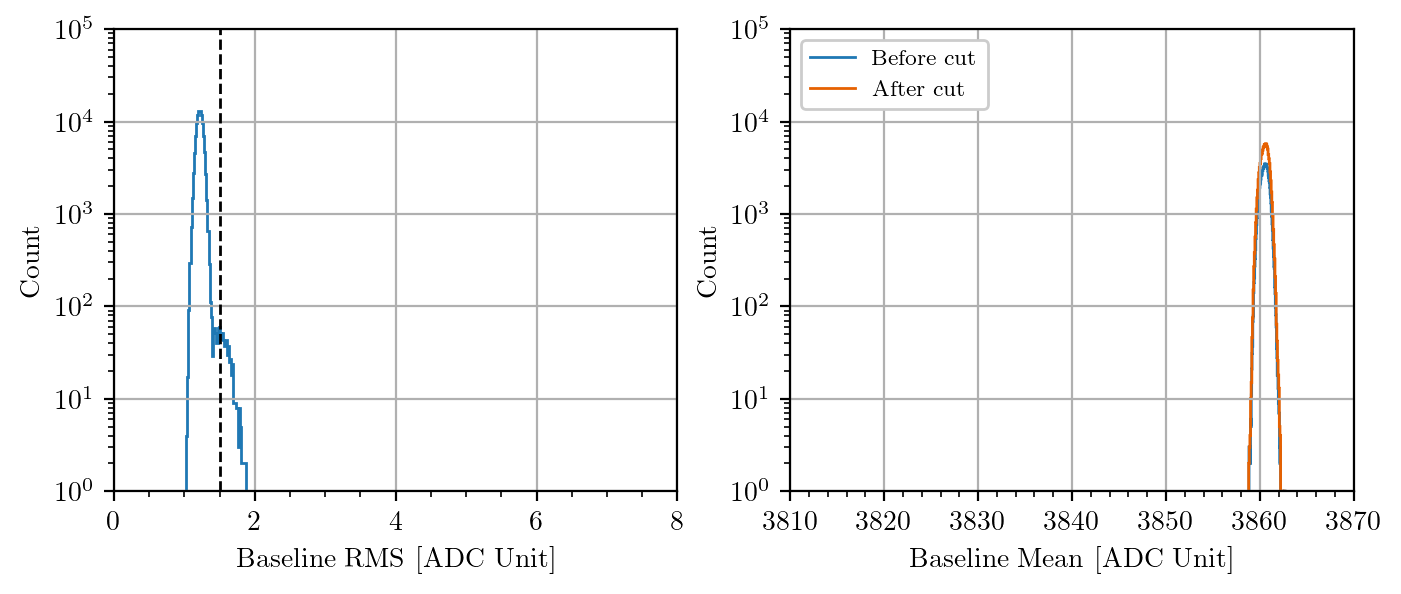

In [52]:
# Make plots for selected dataset
ch = 3
volt = 90
print(f'Plots for ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(mybsl[ch][volt]['rms_hist'],
              mybsl[ch][volt]['rms_bins'])
th = mybsl[ch][volt]['rms_threshold']
axs[0].plot([th, th], [1, 1e5], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(mybsl[ch][volt]['mean_hist'],
              mybsl[ch][volt]['mean_bins'],
              label='Before cut')
axs[1].stairs(mybsl[ch][volt]['mean_hist_cut'],
              mybsl[ch][volt]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e5)
axs[1].set_xlim(mybsl[ch][volt]['mean_bins'][0], mybsl[ch][volt]['mean_bins'][-1])
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Filtered amplitude & DiCT analysis
The PE peak positions are identified with ``scipy.signal.find_peaks``.
Let $A_k$ be the peak position of the $k$-PE peak (including $k=0$). 
The boundary between $k-1$ PEs and $k$ PEs is defined as $(A_{k-1}+A_{k})/2$.
The lower boundary of the 0th PE is $A_0-0.5(A_1-A_0)$ and similarly for the upper boundary of the highest identifiable PE.
One exception is bottom ch3 which has asymmetric peaks. See code for the modified boundary criterion.
The vertical dashed lines in the finger plots represent the boundaries.

Let $P_k$ be the fraction of events within the $k$-PE boundaries. 
It can be fitted by the [compound Poisson distribution](https://ieeexplore.ieee.org/document/5402300) describing a binomial chain process, with parameter $p$ being the DiCT probability and $\mu$ being the Poisson mean of primary PEs.

In [53]:
boundary_par_dict = {}
amp_hist = {}
crosstalk = {}
nbins=2000
hist_range=(-5e2, 5e3)
bin_width = (hist_range[1]-hist_range[0])/nbins
prom,wid,dist=45,4,40

for ch in channels:
    boundary_par_dict[ch] = {}
    amp_hist[ch] = {}
    crosstalk[ch] = {}
    for volt in voltages:
        amp_hist[ch][volt] = {}
        crosstalk[ch][volt] = {}
        boundary_par_dict[ch][volt] = 0.5
        nevents = np.sum(metadata_dict[ch][volt]['data']['bsl_cut'])
        amp_hist[ch][volt]['hist'], amp_hist[ch][volt]['bins'] = np.histogram(
            metadata_dict[ch][volt]['data']['amplitude_trig'].loc[metadata_dict[ch][volt]['data']['bsl_cut']], 
            bins=nbins, range=hist_range
        )
        # find PE peaks in histogram
        p, pdict = scipy.signal.find_peaks(
            amp_hist[ch][volt]['hist'], prominence=prom, width=wid, distance=dist)
        print(f'{volt}V ch{ch} p=', p, ' prom=',pdict['prominences'], ' widths=', pdict['widths'])
        # discriminate different PE counts and calculate probability distribution P_k
        metadata_dict[ch][volt]['data']['pe'] = np.zeros(metadata_dict[ch][volt]['data'].shape[0]).astype(int)
        P_k = []
        npe = len(p)
        pe_cuts_in_bins = []
        bound_par = boundary_par_dict[ch][volt]
        if npe>1:
            for ipe in range(npe):
                if ipe == 0:
                    pe_cuts_in_bins.append(int(1.5*p[0]-0.5*p[1]))
                else:
                    pe_cuts_in_bins.append(int(bound_par*p[ipe]+(1-bound_par)*p[ipe-1]))
                    metadata_dict[ch][volt]['data']['pe'] += (metadata_dict[ch][volt]['data']['amplitude_trig']>pe_cuts_in_bins[-1]*bin_width+hist_range[0]).astype(int)
                    P_k.append([np.sum(amp_hist[ch][volt]['hist'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]])/nevents,
                            np.sqrt(np.sum(amp_hist[ch][volt]['hist'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]]))/nevents])
        amp_hist[ch][volt]['boundaries'] = list(
            np.array(pe_cuts_in_bins)*bin_width+hist_range[0])
        # Save P_k for Vinogradov fit
        if npe>1:
            crosstalk[ch][volt]['y'] = np.array(P_k)[:, 0]
            crosstalk[ch][volt]['yerr'] = np.array(P_k)[:, 1]
            crosstalk[ch][volt]['x'] = np.arange(len(P_k))

90V ch0 p= [184]  prom= [8956.]  widths= [5.15720303]
92V ch0 p= [182 297 394]  prom= [968. 193. 324.]  widths= [  5.5869847   48.38169935 193.76470588]
94V ch0 p= [180 343 518 676 827]  prom= [269. 111. 135. 184. 116.]  widths= [ 5.46583489 43.02788462 61.91666667 99.58333333 64.28571429]
96V ch0 p= [ 178  419  668  904 1184 1418 1653]  prom= [106.  61. 101. 118. 131. 106.  76.]  widths= [ 6.67236025 48.27412281 66.47619048 87.73913043 79.171875   74.
 40.92682927]
98V ch0 p= [ 176  840 1179 1506 1858]  prom= [ 75.  70.  94. 109.  88.]  widths= [  6.66323529  71.36996337  85.          82.77083333 110.69565217]
90V ch1 p= [183]  prom= [5602.]  widths= [4.49052032]
92V ch1 p= [182 251 326 404 470]  prom= [2263.  904.  740.  361.  101.]  widths= [ 4.62587308 25.61328976 33.93137255 37.61830065 25.        ]
94V ch1 p= [181 295 407 512 625 750 839]  prom= [1116.  593.  643.  482.  292.  134.   55.]  widths= [ 4.85540356 25.43058851 33.69987995 42.71652004 51.74910714 37.81403509
 26.561576

Text(0.07, 0.5, 'Count')

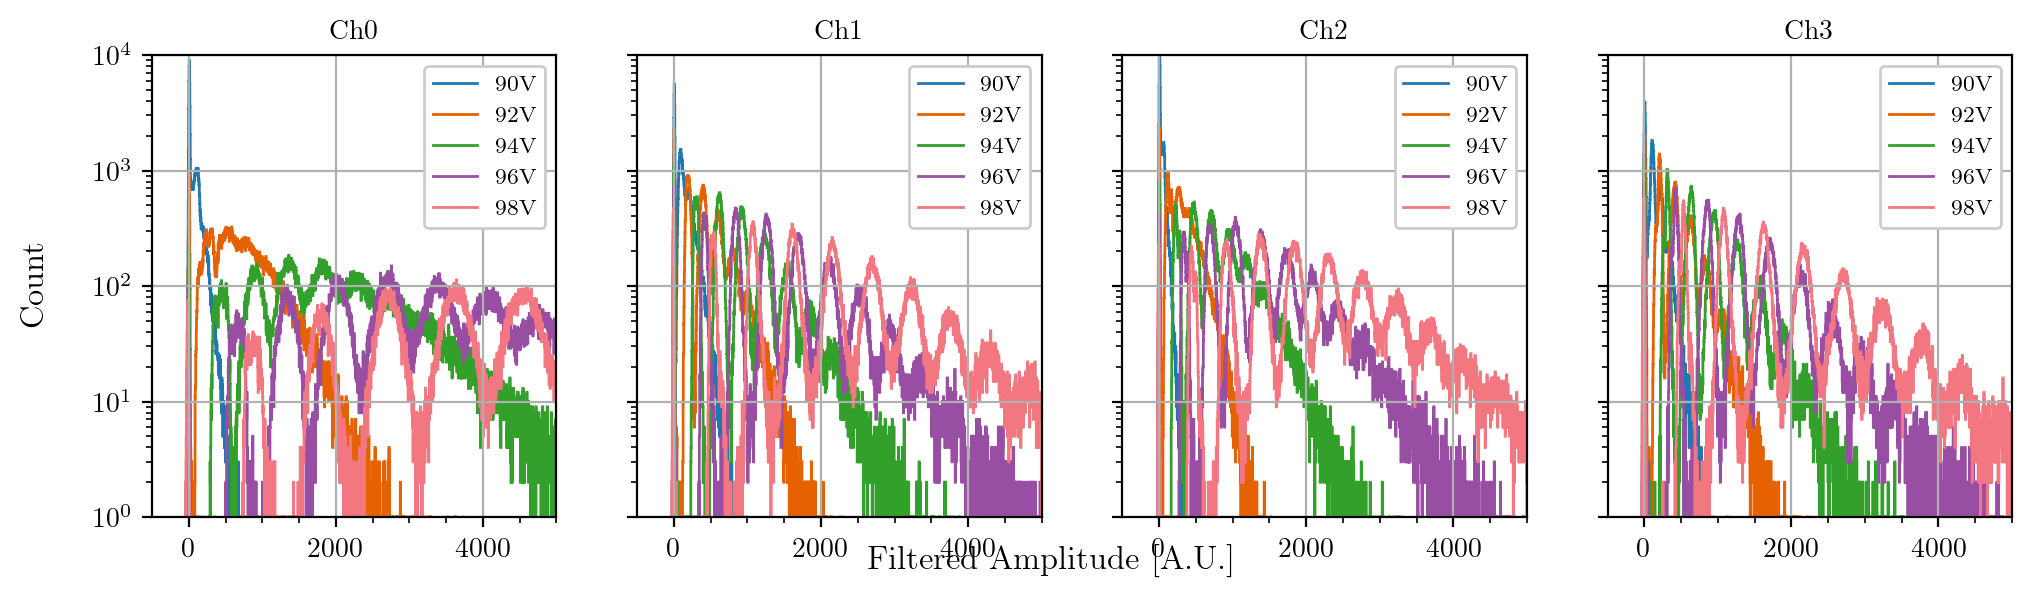

In [54]:
# Make plots for all datasets
# Finger plots
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)

for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        axs[j].stairs(amp_hist[ch][volt]['hist'],
                            amp_hist[ch][volt]['bins'],
                            label=f'{volt}V', color=f'C{k}')
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1, 1e4)
    axs[j].set_xlim(amp_hist[ch][volt]['bins'][0],
                amp_hist[ch][volt]['bins'][-1])
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Ch{ch}')
fig.supxlabel('Filtered Amplitude [A.U.]', y=0.01)
fig.supylabel('Count', x=0.07)

In [55]:
results = {'dict':{}}
voltages = voltages[2:-1]
for ch in channels:
    results['dict'][ch] = {}
    for volt in voltages:
        # Do Vinogradov fit
        if 'x' in crosstalk[ch][volt]:
            crosstalk[ch][volt]['par'], crosstalk[ch][volt]['cov'] = curve_fit(
                func.compound_poisson,
                crosstalk[ch][volt]['x'],
                crosstalk[ch][volt]['y'],
                p0=[3, 0.2], sigma=crosstalk[ch][volt]['yerr'], maxfev=10000)
            # Save fit results
            crosstalk[ch][volt]['dict'] = crosstalk[ch][volt]['par'][1]
            crosstalk[ch][volt]['dict_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(crosstalk[ch][volt]['cov'][1, 1])
            print(f'ch{ch} {volt}V P_dict = {crosstalk[ch][volt]["dict"]:.4f} +/- {crosstalk[ch][volt]["dict_err"]:.4f}')
    results['dict'][ch]['bias'] = voltages
    results['dict'][ch]['dict'] = [crosstalk[ch][volt]['dict'] for volt in voltages]
    results['dict'][ch]['dict_err'] = [crosstalk[ch][volt]['dict_err'] for volt in voltages]

ch0 94V P_dict = 0.0497 +/- 0.0254
ch0 96V P_dict = 0.0538 +/- 0.0172
ch1 94V P_dict = 0.0274 +/- 0.0102
ch1 96V P_dict = 0.0645 +/- 0.0090
ch2 94V P_dict = 0.0341 +/- 0.0160
ch2 96V P_dict = 0.0652 +/- 0.0077
ch3 94V P_dict = 0.0471 +/- 0.0087
ch3 96V P_dict = 0.0636 +/- 0.0058


Text(0.07, 0.5, 'Probability $P_k$')

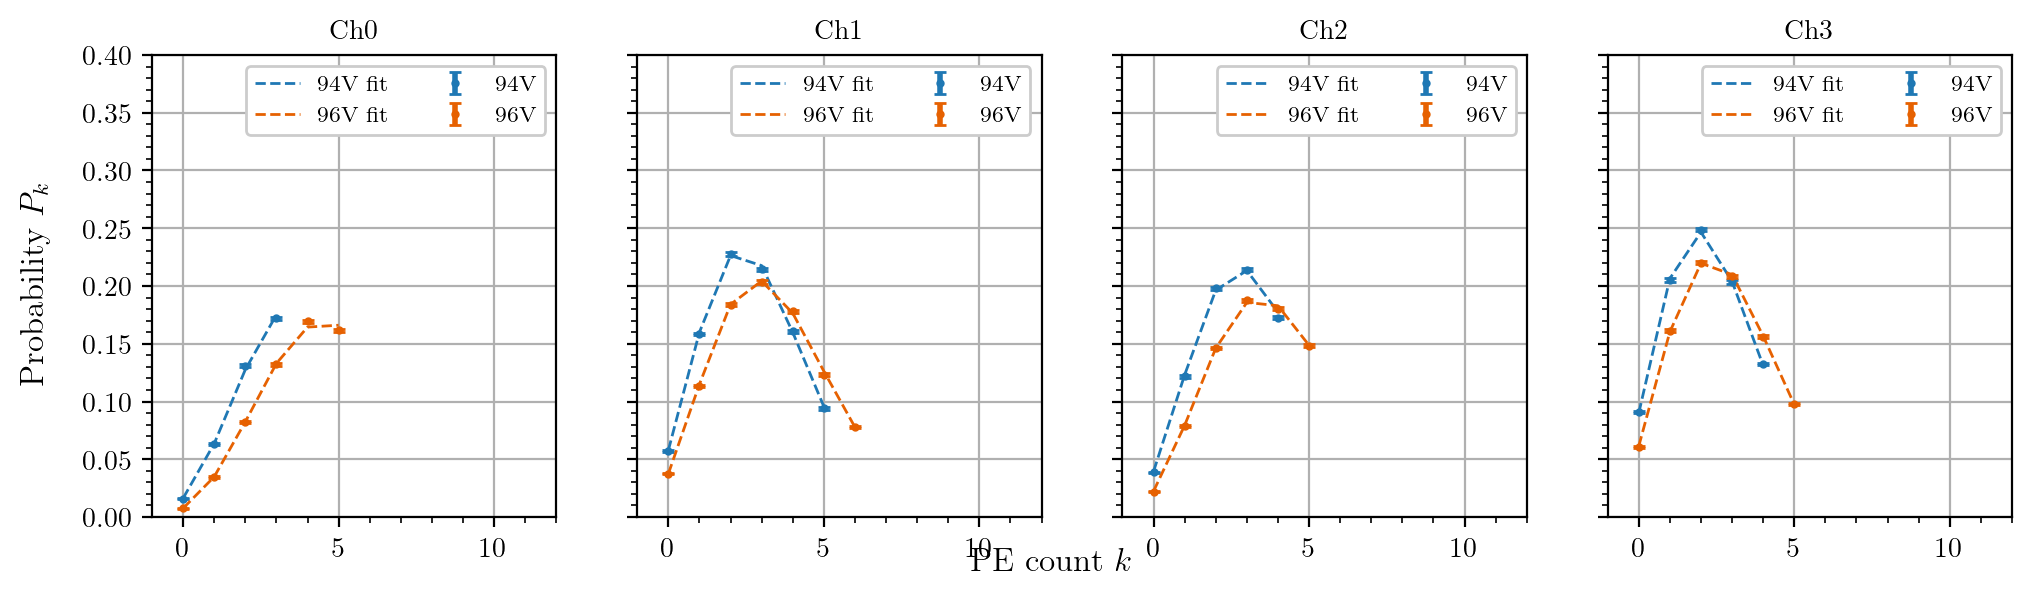

In [56]:
# Make plots for all datasets
# DiCT fits
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        if 'x' in crosstalk[ch][volt]:
            axs[j].errorbar(crosstalk[ch][volt]['x'],
                    crosstalk[ch][volt]['y'],
                    yerr=crosstalk[ch][volt]['yerr'],
                    fmt=f'C{k}o', markersize=2, label=f'{volt}V')
            axs[j].plot(crosstalk[ch][volt]['x'],
                        func.compound_poisson(
                            crosstalk[ch][volt]['x'], *crosstalk[ch][volt]['par']),
                        f'C{k}--', label=f'{volt}V fit', linewidth=1)
    axs[j].legend(loc='upper right', ncol=2)
    axs[j].set_ylim(0, 0.4)
    axs[j].set_xlim(-1, 12)
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Ch{ch}')
fig.supxlabel(r'PE count $k$', y=0.01)
fig.supylabel(r'Probability $P_k$', x=0.07)

Plots for ch1 96V


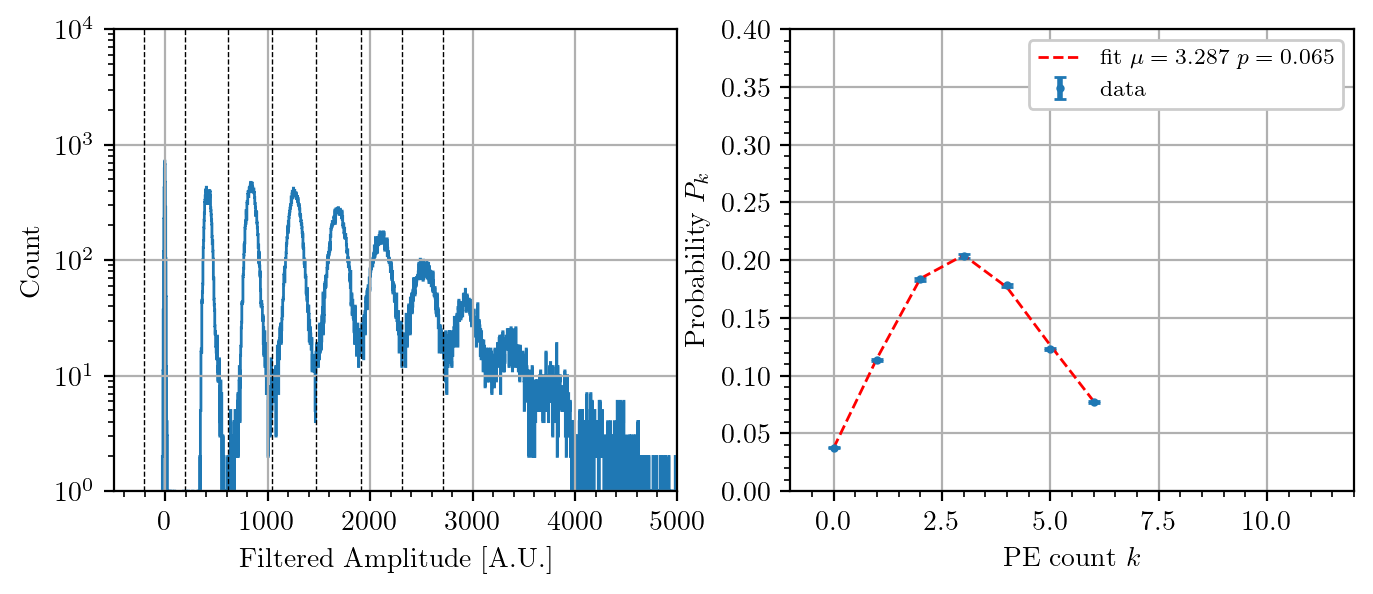

In [58]:
# Make plots for selected datasets
ch = 1
volt = 96
print(f'Plots for ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# filtered amplitude histogram
axs[0].stairs(amp_hist[ch][volt]['hist'],
              amp_hist[ch][volt]['bins'])
for b in amp_hist[ch][volt]['boundaries']:
    axs[0].plot([b, b], [1, 1e4], 'k--', linewidth=0.5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Filtered Amplitude [A.U.]')
axs[0].set_ylabel('Count')
axs[0].set_xlim(amp_hist[ch][volt]['bins'][0],
                amp_hist[ch][volt]['bins'][-1])
axs[0].set_ylim(1, 1e4)
axs[0].minorticks_on()
axs[0].grid()

# Vinogradov fit
axs[1].errorbar(crosstalk[ch][volt]['x'],
                crosstalk[ch][volt]['y'],
                yerr=crosstalk[ch][volt]['yerr'],
                fmt='o', markersize=2, label='data')
axs[1].plot(crosstalk[ch][volt]['x'],
            func.compound_poisson(
                crosstalk[ch][volt]['x'], *crosstalk[ch][volt]['par']),
            'r--', label=r'fit $\mu={:.3f}$ $p={:.3f}$'.format(*crosstalk[ch][volt]['par']), linewidth=1)
axs[1].set_xlabel(r'PE count $k$')
axs[1].set_ylabel(r'Probability $P_k$')
axs[1].set_ylim(0, 0.4)
axs[1].set_xlim(-1, 12)
axs[1].legend(loc='upper right')
axs[1].minorticks_on()
axs[1].grid()

# Integrated charge and afterpulsing analysis
The integral window is $5~\rm\mu s$ post-trigger and $0.5~\rm \mu s$ pre-trigger.
The integrals are grouped by the PE counts $k$ defined with the filtered amplitude (see previous cell).
The integral distribution has a Gaussian left tail but a heavier right tail due to afterpulses.
The part of the histograms near the peak is fitted by a Gaussian PDF to find the peak position, denoted by $I_{k,\rm peak}$.
$I_{k,\rm peak}$ is linear with $k$, and the slope $Q_{\rm peak}$ is the SPE gain of the SiPMs in arbitrary units.<br>

The average of the histogram, excluding overflowing bins (to reject scintillation events that have very high charge integrals), is denoted by $I_{k,\rm avg}$.
It is also linear with $k$, and the slope is denoted by $Q_{\rm avg}$.
The relative difference, $\frac{Q_{\rm avg}}{Q_{\rm peak}}-1$, is the average afterpulse charge per PE enhanced by DiCT.
Therefore, we define the afterpulse charge as $Q_{\rm AP}=(\frac{Q_{\rm avg}}{Q_{\rm peak}}-1)(1-p)$.<br>

The afterpulse *probability* is also estimated using the fraction of events under the Gaussian (i.e. the normalization of Gaussian function) out of total events.
This fraction is the probability that all $k$ cells have no afterpulse, denoted by $1-P_{\rm AP}(k)$. It should equal to $(1-P_{\rm AP})^k$, where $P_{\rm AP}$ is the afterpulse probability per PE.
$P_{\rm AP}$ extracted from the fits are consistent with $Q_{\rm AP}$, indicating that most afterpulses are a full PE.

The breakdown voltage is obtained by a linear fit to $Q_{\rm peak}$ as a function of bias $V$ using $Q_{\rm peak}=C(V-V_{\rm bd})$.
A comparison of breakdown voltage across channels is further down in the notebook.

In [59]:
charge_hist = {}
charge_fits = {}
ap_prob = {}
fit_range_thre = (0.02, 0.45)
hist_range = (-2e3, 1.6e4)
nbins = 1000

for ch in channels:
    charge_hist[ch] = {}
    charge_fits[ch] = {}
    ap_prob[ch] = {}
    for volt in voltages:
        charge_hist[ch][volt] = {}
        charge_fits[ch][volt] = {}
        ap_prob[ch][volt] = {}
        range_min = hist_range[0]
        range_max = hist_range[1]+(volt-90)*1e3
        bin_width = (range_max-range_min)/nbins
        for pe in np.arange(1,len(amp_hist[ch][volt]['boundaries'])-1):
            charge_hist[ch][volt][pe] = {}
            charge_fits[ch][volt][pe] = {}
            ap_prob[ch][volt][pe] = {}
            # Generate histograms
            selected_charges = metadata_dict[ch][volt]['data']['integral_5p00us'].loc[(metadata_dict[ch][volt]['data']['bsl_cut'])&(metadata_dict[ch][volt]['data']['pe']==pe)&(metadata_dict[ch][volt]['data']['integral_5p00us']<range_max)&(metadata_dict[ch][volt]['data']['integral_5p00us']>range_min)]
            charge_hist[ch][volt][pe]['hist'], charge_hist[ch][volt][pe]['bins'] = np.histogram(
                selected_charges, bins=nbins, range=(range_min, range_max))
            # find appropriate fit range
            peak_bin = np.argmax(charge_hist[ch][volt][pe]['hist'])
            fit_min = peak_bin
            while charge_hist[ch][volt][pe]['hist'][fit_min] > fit_range_thre[0]*charge_hist[ch][volt][pe]['hist'][peak_bin]:
                fit_min -= 1
            if charge_hist[ch][volt][pe]['hist'][fit_min] == 0:
                fit_min += 1
            charge_fits[ch][volt][pe]['min_bin'] = fit_min
            fit_max = peak_bin
            while charge_hist[ch][volt][pe]['hist'][fit_max] > fit_range_thre[1]*charge_hist[ch][volt][pe]['hist'][peak_bin]:
                fit_max += 1
            if charge_hist[ch][volt][pe]['hist'][fit_max] == 0:
                fit_max -= 1
            charge_fits[ch][volt][pe]['max_bin'] = fit_max
            # Gaussian fits
            charge_fits[ch][volt][pe]['par'], charge_fits[ch][volt][pe]['cov'] = curve_fit(
                func.gauss_normalized,
                0.5*(charge_hist[ch][volt][pe]['bins'][fit_min:fit_max]+charge_hist[ch][volt][pe]['bins'][fit_min+1:fit_max+1]),
                charge_hist[ch][volt][pe]['hist'][fit_min:fit_max],
                p0=[charge_hist[ch][volt][pe]['hist'][peak_bin]*(fit_max-fit_min)*bin_width/3,
                    peak_bin*bin_width+range_min,
                    (fit_max-fit_min)*bin_width/3],
                sigma=np.sqrt(charge_hist[ch][volt][pe]['hist'][fit_min:fit_max]),
                maxfev=100000)
            # Store peak positions and averages
            charge_fits[ch][volt][pe]['Ipeak'] = charge_fits[ch][volt][pe]['par'][1]
            charge_fits[ch][volt][pe]['Ipeak_err'] = func.error_distance(
                df=3, sigma=1)*np.sqrt(charge_fits[ch][volt][pe]['cov'][1, 1])
            charge_fits[ch][volt][pe]['Iavg'] = np.mean(selected_charges)
            charge_fits[ch][volt][pe]['Iavg_err'] = np.std(selected_charges)/np.sqrt(len(selected_charges))
            # Store afterpulse probability
            ap_prob[ch][volt][pe]['prob'] = charge_fits[ch][volt][pe]['par'][0]/bin_width/len(selected_charges)
            ap_prob[ch][volt][pe]['prob_err'] = np.sqrt(ap_prob[ch][volt][pe]['prob']*(1-ap_prob[ch][volt][pe]['prob'])/len(selected_charges))


Text(0.07, 0.5, 'Count')

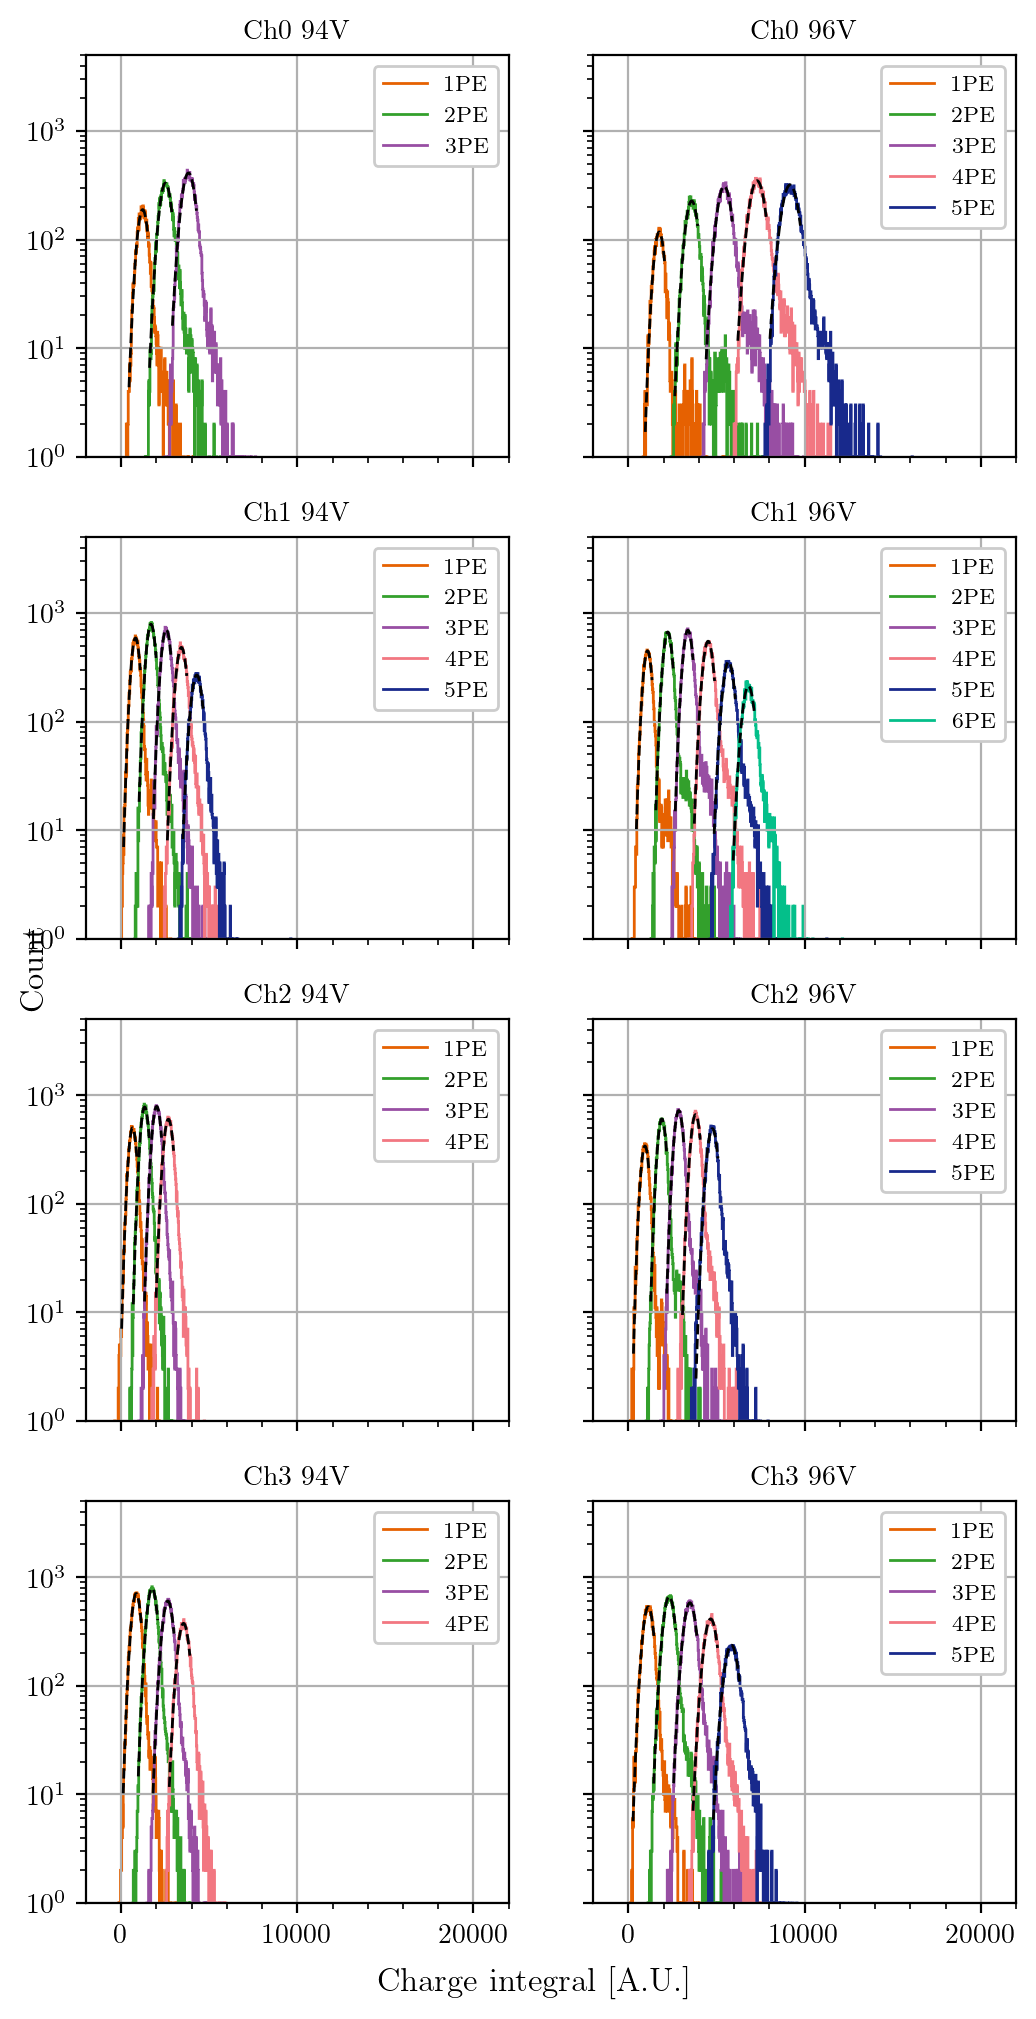

In [64]:
# Make plots for all datasets
# Charge histograms
fig, axs = plt.subplots(4, len(voltages), sharex=True, sharey=True)
fig.set_size_inches(3*len(voltages),12)

for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        for pe in charge_hist[ch][volt].keys():
            axs[j, k].stairs(charge_hist[ch][volt][pe]['hist'],
                                    charge_hist[ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
            fit_min = charge_fits[ch][volt][pe]['min_bin']
            fit_max = charge_fits[ch][volt][pe]['max_bin']
            axs[j, k].plot(charge_hist[ch][volt][pe]['bins'][fit_min:fit_max], func.gauss_normalized(
                charge_hist[ch][volt][pe]['bins'][fit_min:fit_max], *charge_fits[ch][volt][pe]['par']), f'k--', linewidth=1)
        axs[j, k].legend(loc='upper right')
        axs[j, k].set_ylim(1, 5e3)
        xmin = charge_hist[ch][volt][list(
            charge_hist[ch][volt].keys())[-1]]['bins'][0]
        xmax = charge_hist[ch][volt][list(
            charge_hist[ch][volt].keys())[-1]]['bins'][-1]
        axs[j, k].set_xlim(xmin, xmax)
        axs[j, k].set_yscale('log')
        axs[j, k].minorticks_on()
        axs[j, k].grid()
        axs[j, k].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'Charge integral [A.U.]', y=0.07)
fig.supylabel(r'Count', x=0.07)

In [65]:
gain_peak_fits = {}
gain_avg_fits = {}
results['gain'] = {}
for ch in channels:
    gain_peak_fits[ch] = {}
    gain_avg_fits[ch] = {}
    results['gain'][ch] = {}
    for volt in voltages:
        gain_peak_fits[ch][volt] = {}
        gain_avg_fits[ch][volt] = {}
        # Qpeak fit
        gain_peak_fits[ch][volt]['x'] = np.array(list(charge_fits[ch][volt].keys()))
        gain_peak_fits[ch][volt]['y'] = np.array([charge_fits[ch][volt][pe]['Ipeak'] for pe in charge_fits[ch][volt].keys()])
        gain_peak_fits[ch][volt]['yerr'] = np.array([charge_fits[ch][volt][pe]['Ipeak_err'] for pe in charge_fits[ch][volt].keys()])
        gain_peak_fits[ch][volt]['par'], gain_peak_fits[ch][volt]['cov'] = curve_fit(
            func.line_simple,
            gain_peak_fits[ch][volt]['x'],
            gain_peak_fits[ch][volt]['y'],
            sigma=gain_peak_fits[ch][volt]['yerr'],
            p0=[500, 0],
            maxfev=10000)
        gain_peak_fits[ch][volt]['Qpeak'] = gain_peak_fits[ch][volt]['par'][0]
        gain_peak_fits[ch][volt]['Qpeak_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(gain_peak_fits[ch][volt]['cov'][0, 0])
        # Qavg fit
        gain_avg_fits[ch][volt]['x'] = np.array(list(charge_fits[ch][volt].keys()))
        gain_avg_fits[ch][volt]['y'] = np.array([charge_fits[ch][volt][pe]['Iavg'] for pe in charge_fits[ch][volt].keys()])
        gain_avg_fits[ch][volt]['yerr'] = np.array([charge_fits[ch][volt][pe]['Iavg_err'] for pe in charge_fits[ch][volt].keys()])
        gain_avg_fits[ch][volt]['par'], gain_avg_fits[ch][volt]['cov'] = curve_fit(
            func.line_simple,
            gain_avg_fits[ch][volt]['x'],
            gain_avg_fits[ch][volt]['y'],
            sigma=gain_avg_fits[ch][volt]['yerr'],
            p0=[500, 0],
            maxfev=10000)
        gain_avg_fits[ch][volt]['Qavg'] = gain_avg_fits[ch][volt]['par'][0]
        gain_avg_fits[ch][volt]['Qavg_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(gain_avg_fits[ch][volt]['cov'][0, 0])
    results['gain'][ch]['bias'] = voltages
    results['gain'][ch]['gain'] = [gain_peak_fits[ch][volt]['Qpeak'] for volt in voltages]
    results['gain'][ch]['gain_err'] = [gain_peak_fits[ch][volt]['Qpeak_err'] for volt in voltages]

Text(0.07, 0.5, 'Charge integral $I_k$ [A.U.]')

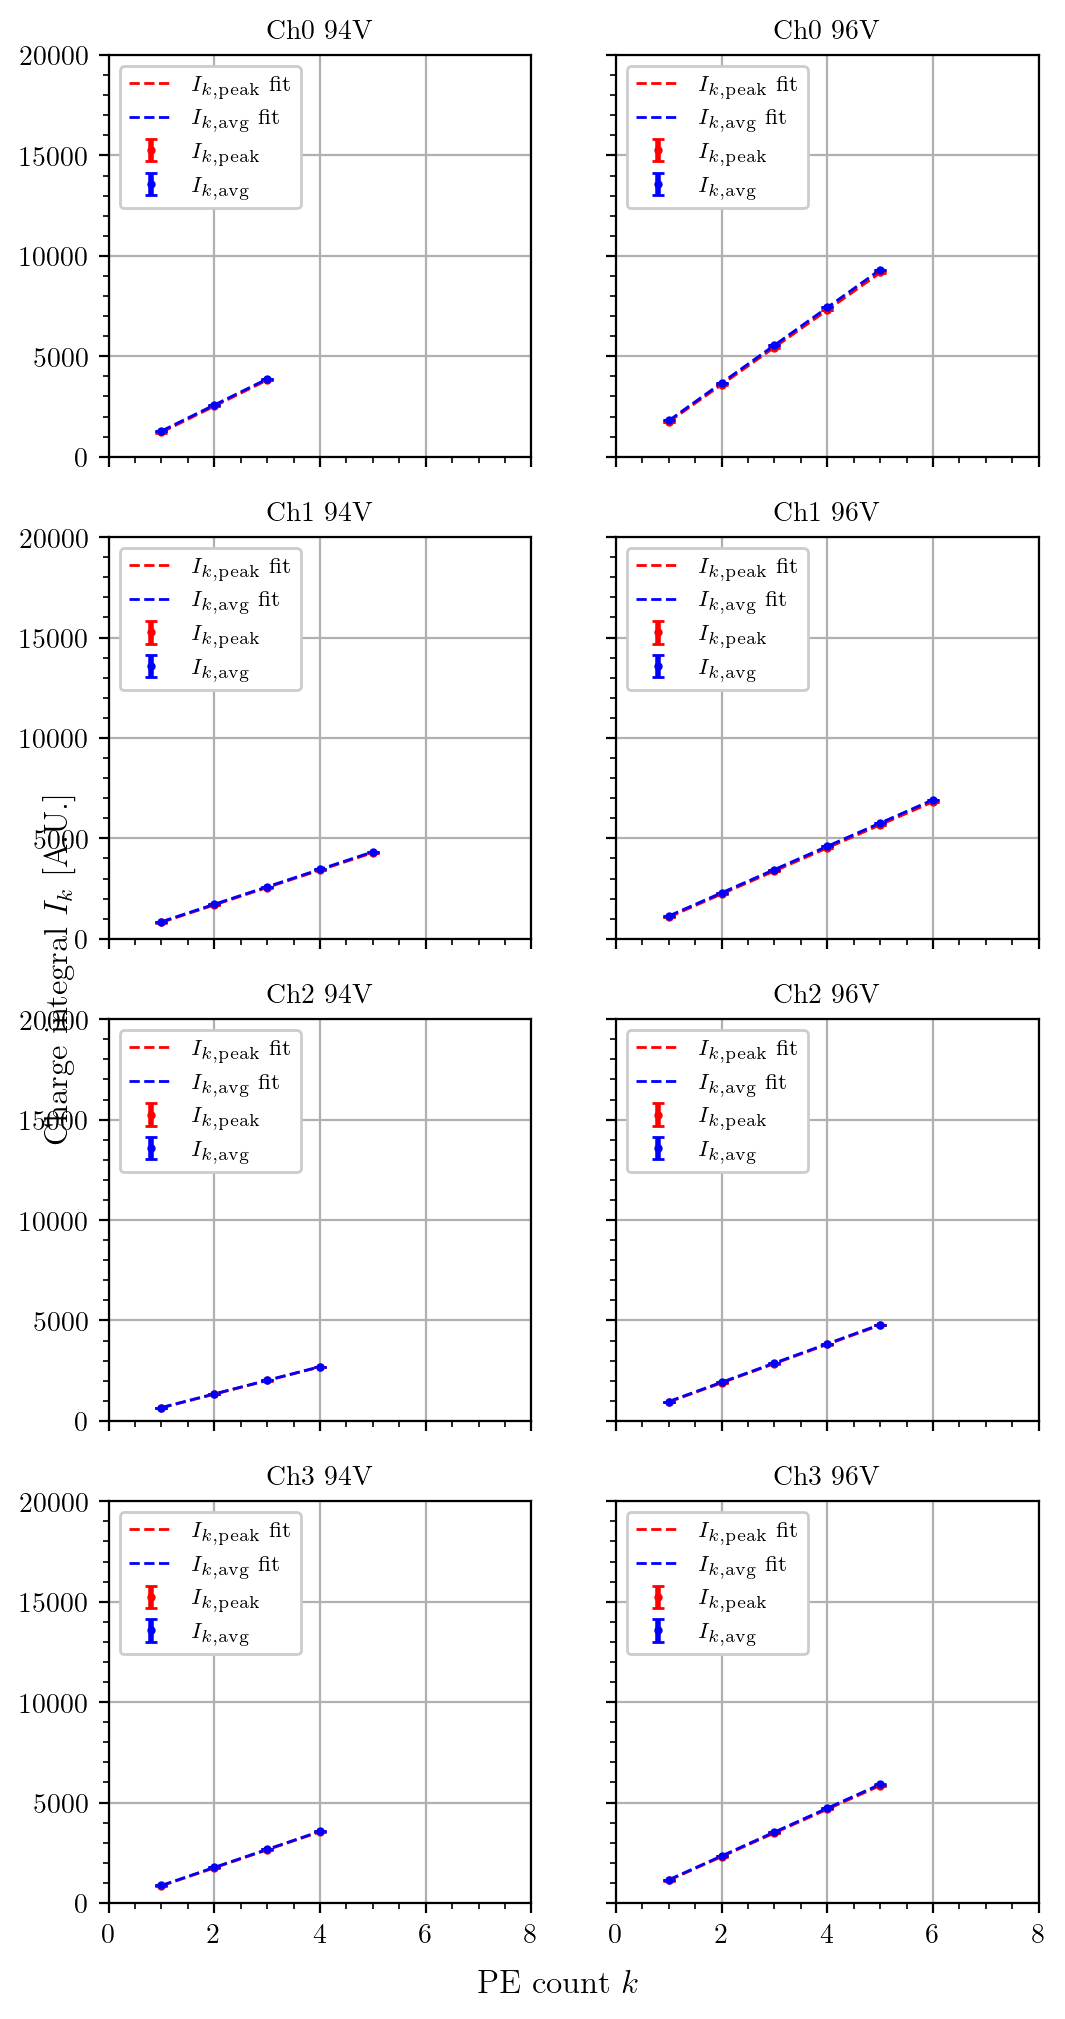

In [68]:
# Make plots for all datasets
# Charge-PE fits
fig, axs = plt.subplots(4, len(voltages), sharex=True, sharey=True)
fig.set_size_inches(3*len(voltages),12)
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        axs[j, k].errorbar(gain_peak_fits[ch][volt]['x'], gain_peak_fits[ch][volt]['y'],
                                yerr=gain_peak_fits[ch][volt]['yerr'], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
        axs[j, k].plot(gain_peak_fits[ch][volt]['x'], func.line_simple(gain_peak_fits[ch][volt]
                            ['x'], *gain_peak_fits[ch][volt]['par']), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        axs[j, k].errorbar(gain_avg_fits[ch][volt]['x'], gain_avg_fits[ch][volt]['y'],
                                yerr=gain_avg_fits[ch][volt]['yerr'], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
        axs[j, k].plot(gain_avg_fits[ch][volt]['x'], func.line_simple(gain_avg_fits[ch][volt]
                            ['x'], *gain_avg_fits[ch][volt]['par']), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        axs[j, k].legend(loc='upper left')
        axs[j, k].set_ylim(0, 2e4)
        axs[j, k].set_xlim(0, 8)
        axs[j, k].minorticks_on()
        axs[j, k].grid()
        axs[j, k].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'PE count $k$', y=0.07)
fig.supylabel(r'Charge integral $I_k$ [A.U.]', x=0.07)

In [69]:
ap_charge = {}
ap_prob_fits = {}
results['ap_charge'] = {}
results['ap_prob'] = {}

for ch in channels:
    ap_charge[ch] = {}
    ap_prob_fits[ch] = {}
    results['ap_charge'][ch] = {}
    results['ap_prob'][ch] = {}
    for volt in voltages:
        ap_charge[ch][volt] = {}
        ap_prob_fits[ch][volt] = {}
        # Afterpulse charge
        ap_charge[ch][volt]['Qap'] = gain_avg_fits[ch][volt]['Qavg']/gain_peak_fits[ch][volt]['Qpeak'] - 1
        ap_charge[ch][volt]['Qap_err'] = (1+ap_charge[ch][volt]['Qap'])*np.sqrt((gain_avg_fits[ch][volt]['Qavg_err']/gain_avg_fits[ch][volt]['Qavg'])**2+(gain_peak_fits[ch][volt]['Qpeak_err']/gain_peak_fits[ch][volt]['Qpeak'])**2)
        ap_charge[ch][volt]['Qap'] *= 1-crosstalk[ch][volt]['dict']  # correct for APxDiCT
        ap_charge[ch][volt]['Qap_err'] *= 1-crosstalk[ch][volt]['dict']  # correct for APxDiCT
        # Afterpulse probability fit
        ap_prob_fits[ch][volt]['x'] = np.array(list(ap_prob[ch][volt].keys()))
        ap_prob_fits[ch][volt]['y'] = [ap_prob[ch][volt][pe]['prob'] for pe in ap_prob[ch][volt].keys()]
        ap_prob_fits[ch][volt]['yerr'] = [ap_prob[ch][volt][pe]['prob_err'] for pe in ap_prob[ch][volt].keys()]
        ap_prob_fits[ch][volt]['par'], ap_prob_fits[ch][volt]['cov'] = curve_fit(
            func.power,
            ap_prob_fits[ch][volt]['x'],
            ap_prob_fits[ch][volt]['y'],
            sigma=ap_prob_fits[ch][volt]['yerr'],
            p0=[0.9],
            maxfev=10000)
        ap_prob_fits[ch][volt]['Pap'] = 1-ap_prob_fits[ch][volt]['par'][0]
        ap_prob_fits[ch][volt]['Pap_err'] = func.error_distance(df=1, sigma=1)*np.sqrt(ap_prob_fits[ch][volt]['cov'][0, 0])
    # Qap-Vbias
    results['ap_charge'][ch]['bias'] = voltages
    results['ap_charge'][ch]['ap_charge'] = [ap_charge[ch][volt]['Qap'] for volt in voltages]
    results['ap_charge'][ch]['ap_charge_err'] = [ap_charge[ch][volt]['Qap_err'] for volt in voltages]
    # Pap-Vbias
    results['ap_prob'][ch]['bias'] = voltages
    results['ap_prob'][ch]['ap_prob'] = [ap_prob_fits[ch][volt]['Pap'] for volt in voltages]
    results['ap_prob'][ch]['ap_prob_err'] = [ap_prob_fits[ch][volt]['Pap_err'] for volt in voltages]

Text(0.03, 0.5, '$1-P_{\\rm AP}(k)$')

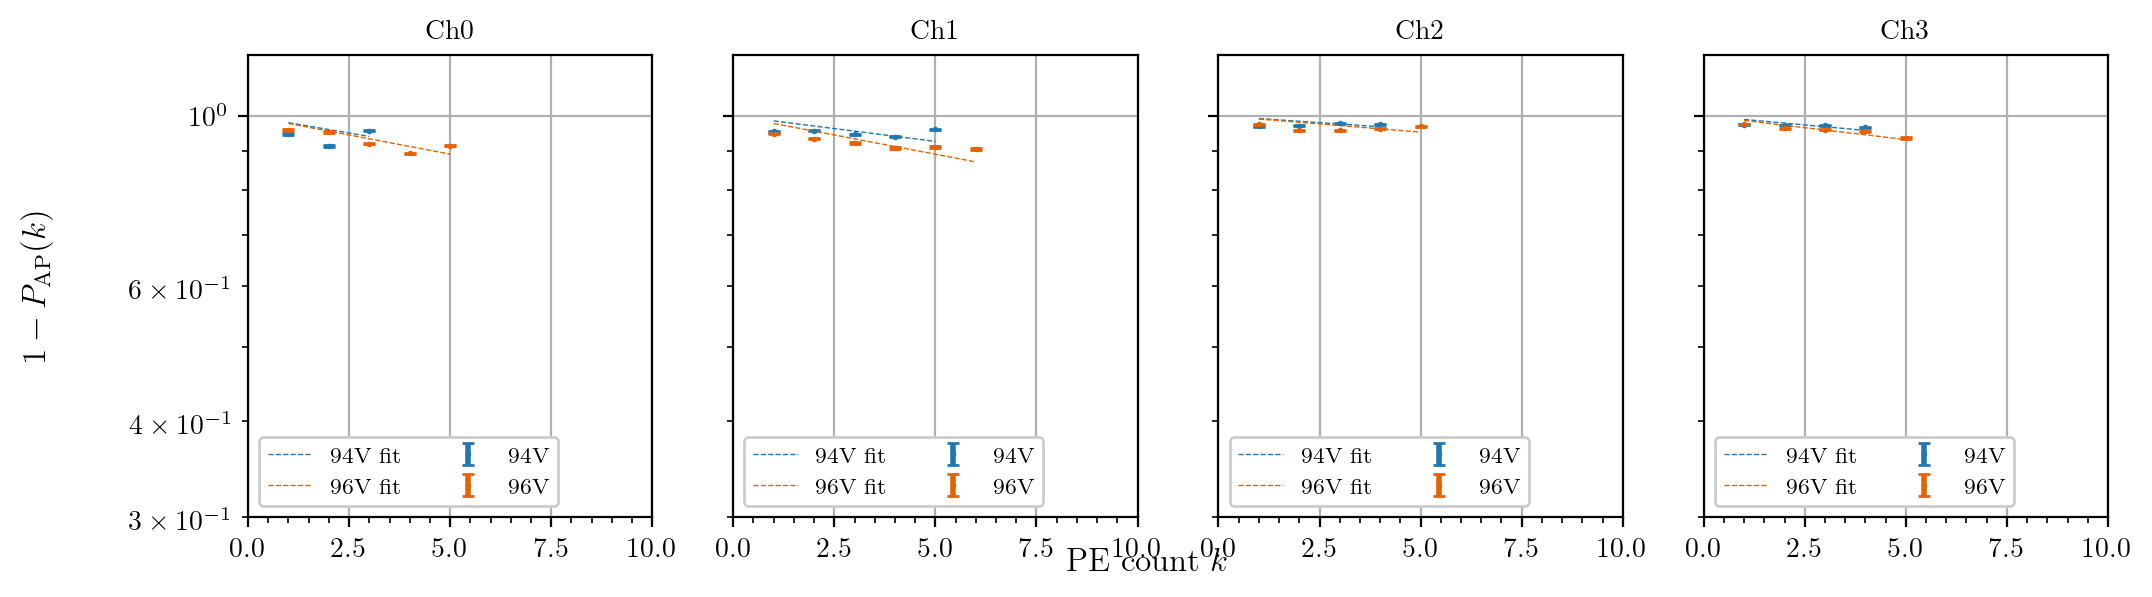

In [70]:
# Make plots for all datasets
# Afterpulse probability fits
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        axs[j].errorbar(ap_prob_fits[ch][volt]['x'], ap_prob_fits[ch][volt]['y'],
                            yerr=ap_prob_fits[ch][volt]['yerr'], fmt=f'C{k}o', markersize=1, label=f'{volt}V')
        axs[j].plot(ap_prob_fits[ch][volt]['x'], func.power(ap_prob_fits[ch][volt]['x'],
                        *ap_prob_fits[ch][volt]['par']), f'C{k}--', linewidth=0.5, label=f'{volt}V fit')
    axs[j].legend(loc='lower left', ncol=2)
    axs[j].set_ylim(0.3, 1.2)
    axs[j].set_xlim(0, 10)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Ch{ch}')
fig.supxlabel(r'PE count $k$', y=0.01)
fig.supylabel(r'$1-P_{\rm AP}(k)$', x=0.03)

Plots for ch3 94V


(0.0, 1.0, 0.0, 1.0)

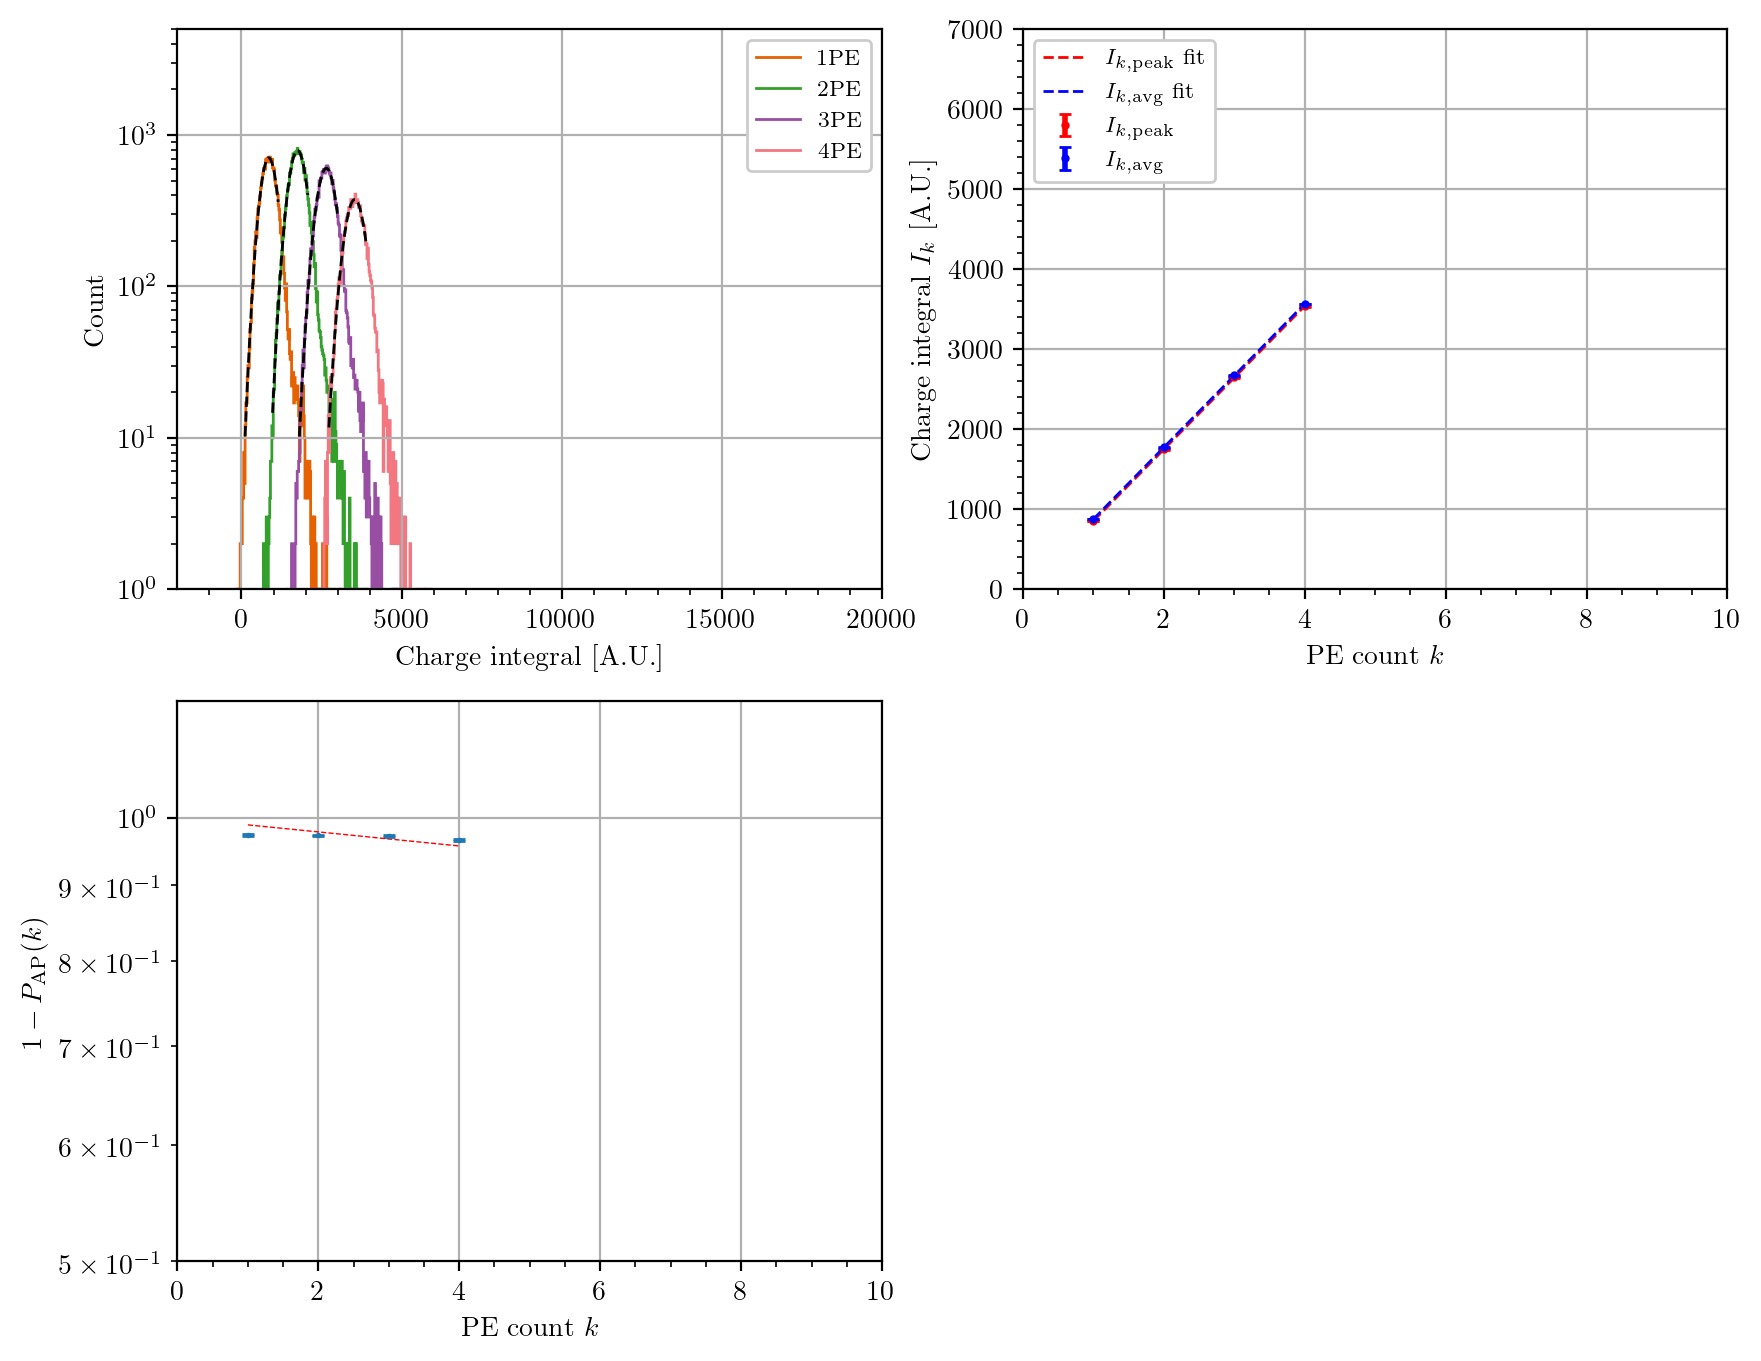

In [73]:
# Make plots for selected datasets
ch = 3
volt = 94
print(f'Plots for ch{ch} {volt}V')
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

# charge histograms
for pe in charge_hist[ch][volt].keys():
    axs[0, 0].stairs(charge_hist[ch][volt][pe]['hist'],
                     charge_hist[ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
    fit_min = charge_fits[ch][volt][pe]['min_bin']
    fit_max = charge_fits[ch][volt][pe]['max_bin']
    axs[0, 0].plot(charge_hist[ch][volt][pe]['bins'][fit_min:fit_max], func.gauss_normalized(
        charge_hist[ch][volt][pe]['bins'][fit_min:fit_max], *charge_fits[ch][volt][pe]['par']), f'k--', linewidth=1)
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_ylim(1, 5e3)
xmin = charge_hist[ch][volt][list(
    charge_hist[ch][volt].keys())[-1]]['bins'][0]
xmax = charge_hist[ch][volt][list(
    charge_hist[ch][volt].keys())[-1]]['bins'][-1]
axs[0, 0].set_xlim(xmin, xmax)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel(r'Charge integral [A.U.]')
axs[0, 0].set_ylabel(r'Count')
axs[0, 0].minorticks_on()
axs[0, 0].grid()

# charge-pe linear fits
axs[0, 1].errorbar(gain_peak_fits[ch][volt]['x'], gain_peak_fits[ch][volt]['y'],
                   yerr=gain_peak_fits[ch][volt]['yerr'], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
axs[0, 1].plot(gain_peak_fits[ch][volt]['x'], func.line_simple(gain_peak_fits[ch][volt]
               ['x'], *gain_peak_fits[ch][volt]['par']), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
axs[0, 1].errorbar(gain_avg_fits[ch][volt]['x'], gain_avg_fits[ch][volt]['y'],
                   yerr=gain_avg_fits[ch][volt]['yerr'], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
axs[0, 1].plot(gain_avg_fits[ch][volt]['x'], func.line_simple(gain_avg_fits[ch][volt]
               ['x'], *gain_avg_fits[ch][volt]['par']), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
axs[0, 1].legend()
axs[0, 1].set_xlabel(r'PE count $k$')
axs[0, 1].set_ylabel(r'Charge integral $I_k$ [A.U.]')
axs[0, 1].set_xlim(0, 10)
axs[0, 1].set_ylim(0, 7e3)
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].minorticks_on()

# afterpulse probability
axs[1, 0].errorbar(ap_prob_fits[ch][volt]['x'],
                   ap_prob_fits[ch][volt]['y'],
                   yerr=ap_prob_fits[ch][volt]['yerr'],
                   fmt='o',
                   markersize=1)
axs[1, 0].plot(ap_prob_fits[ch][volt]['x'],
               func.power(ap_prob_fits[ch][volt]['x'],
                          *ap_prob_fits[ch][volt]['par']),
               'r--',
               linewidth=0.5)
axs[1, 0].set_xlim(0, 10)
axs[1, 0].set_ylim(0.5, 1.2)
axs[1, 0].set_yscale('log')
axs[1, 0].minorticks_on()
axs[1, 0].grid()
axs[1, 0].set_xlabel(r'PE count $k$')
axs[1, 0].set_ylabel(r'$1-P_{\rm AP}(k)$')

# empty figure
axs[1, 1].axis('off')

In [74]:
nsipms = 2
vbd_fits = {}
results['vbd'] = {}
init_pars=[100,55]
for ch in channels:
    vbd_fits[ch] = {}
    results['vbd'][ch] = {}
    vbd_fits[ch]['x'] = voltages
    vbd_fits[ch]['y'] = [gain_peak_fits[ch][volt]['Qpeak'] for volt in voltages]
    vbd_fits[ch]['yerr'] = [gain_peak_fits[ch][volt]['Qpeak_err'] for volt in voltages]
    vbd_fits[ch]['par'], vbd_fits[ch]['cov'] = curve_fit(
        func.line,
        vbd_fits[ch]['x'],
        vbd_fits[ch]['y'],
        sigma=vbd_fits[ch]['yerr'],
        p0=init_pars,
        maxfev=10000)
    vbd_fits[ch]['vbd'] = vbd_fits[ch]['par'][1]
    vbd_fits[ch]['vbd_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(vbd_fits[ch]['cov'][1, 1])
    print(f'ch{ch} Vbd = {vbd_fits[ch]["vbd"]:.2f} +/- {vbd_fits[ch]["vbd_err"]:.2f} V')
    results['vbd'][ch]['vbd_sipm'] = vbd_fits[ch]['vbd']/nsipms
    results['vbd'][ch]['vbd_sipm_err'] = vbd_fits[ch]['vbd_err']/nsipms
    results['dict'][ch]['ov'] = np.array(results['dict'][ch]['bias'])/nsipms-results['vbd'][ch]['vbd_sipm']
    results['dict'][ch]['ov_err'] = np.ones(results['dict'][ch]['ov'].shape[0])*results['vbd'][ch]['vbd_sipm_err']
    results['ap_charge'][ch]['ov'] = np.array(results['ap_charge'][ch]['bias'])/nsipms-results['vbd'][ch]['vbd_sipm']
    results['ap_charge'][ch]['ov_err'] = np.ones(results['ap_charge'][ch]['ov'].shape[0])*results['vbd'][ch]['vbd_sipm_err']
    results['ap_prob'][ch]['ov'] = np.array(results['ap_prob'][ch]['bias'])/nsipms-results['vbd'][ch]['vbd_sipm']
    results['ap_prob'][ch]['ov_err'] = np.ones(results['ap_prob'][ch]['ov'].shape[0])*results['vbd'][ch]['vbd_sipm_err']
    results['gain'][ch]['ov'] = np.array(results['gain'][ch]['bias'])/nsipms-results['vbd'][ch]['vbd_sipm']
    results['gain'][ch]['ov_err'] = np.ones(results['gain'][ch]['ov'].shape[0])*results['vbd'][ch]['vbd_sipm_err']

ch0 Vbd = 89.33 +/- inf V
ch1 Vbd = 87.82 +/- inf V
ch2 Vbd = 89.12 +/- inf V
ch3 Vbd = 87.68 +/- inf V


(0.0, 5000.0)

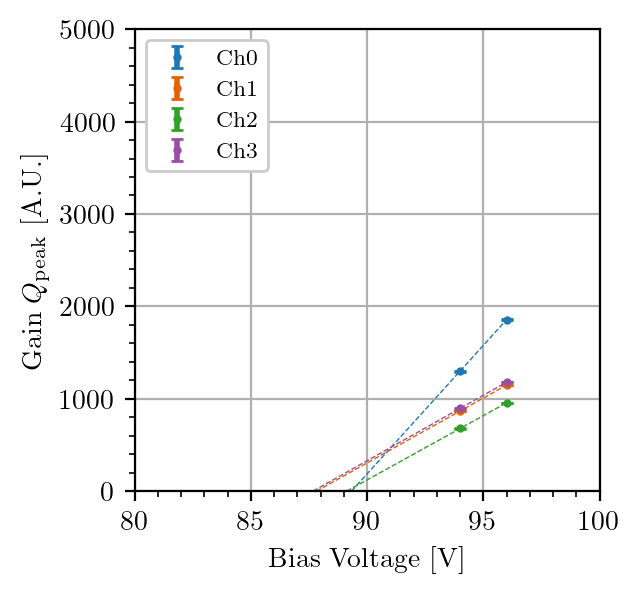

In [75]:
# Make plots for all datasets
# Gain-Vbias linear fits
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
for ch in channels:
    ax.errorbar(vbd_fits[ch]['x'],
                vbd_fits[ch]['y'],
                yerr=vbd_fits[ch]['yerr'],
                label=f'Ch{ch}', fmt='C{}o'.format(ch), markersize=2)
    ax.plot(sorted(voltages + [vbd_fits[ch]['vbd']]),
            func.line(np.array(sorted(voltages + [vbd_fits[ch]['vbd']])), *vbd_fits[ch]['par']),
            '--', linewidth=0.5)
ax.legend(loc='upper left')
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
ax.grid()
ax.minorticks_on()
ax.set_xlim(80, 100)
ax.set_ylim(0, 5.0e3)


Plots for ch3


(0.0, 5000.0)

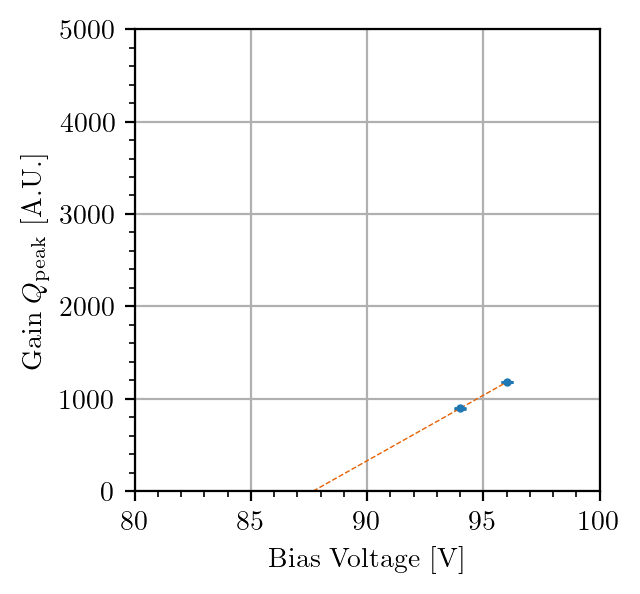

In [76]:
# Make plots for selected datasets
ch = 3
print(f'Plots for ch{ch}')
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
# Gain-Vbias linear fits
ax.errorbar(vbd_fits[ch]['x'],
            vbd_fits[ch]['y'],
            yerr=vbd_fits[ch]['yerr'],
            label=f'ch{ch}', fmt='o', markersize=2)
ax.plot(sorted(voltages + [vbd_fits[ch]['vbd']]),
        func.line(np.array(sorted(voltages + [vbd_fits[ch]['vbd']])), *vbd_fits[ch]['par']),
        '--', linewidth=0.5)
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
ax.grid()
ax.minorticks_on()
ax.set_xlim(80, 100)
ax.set_ylim(0, 5e3)


# Summary

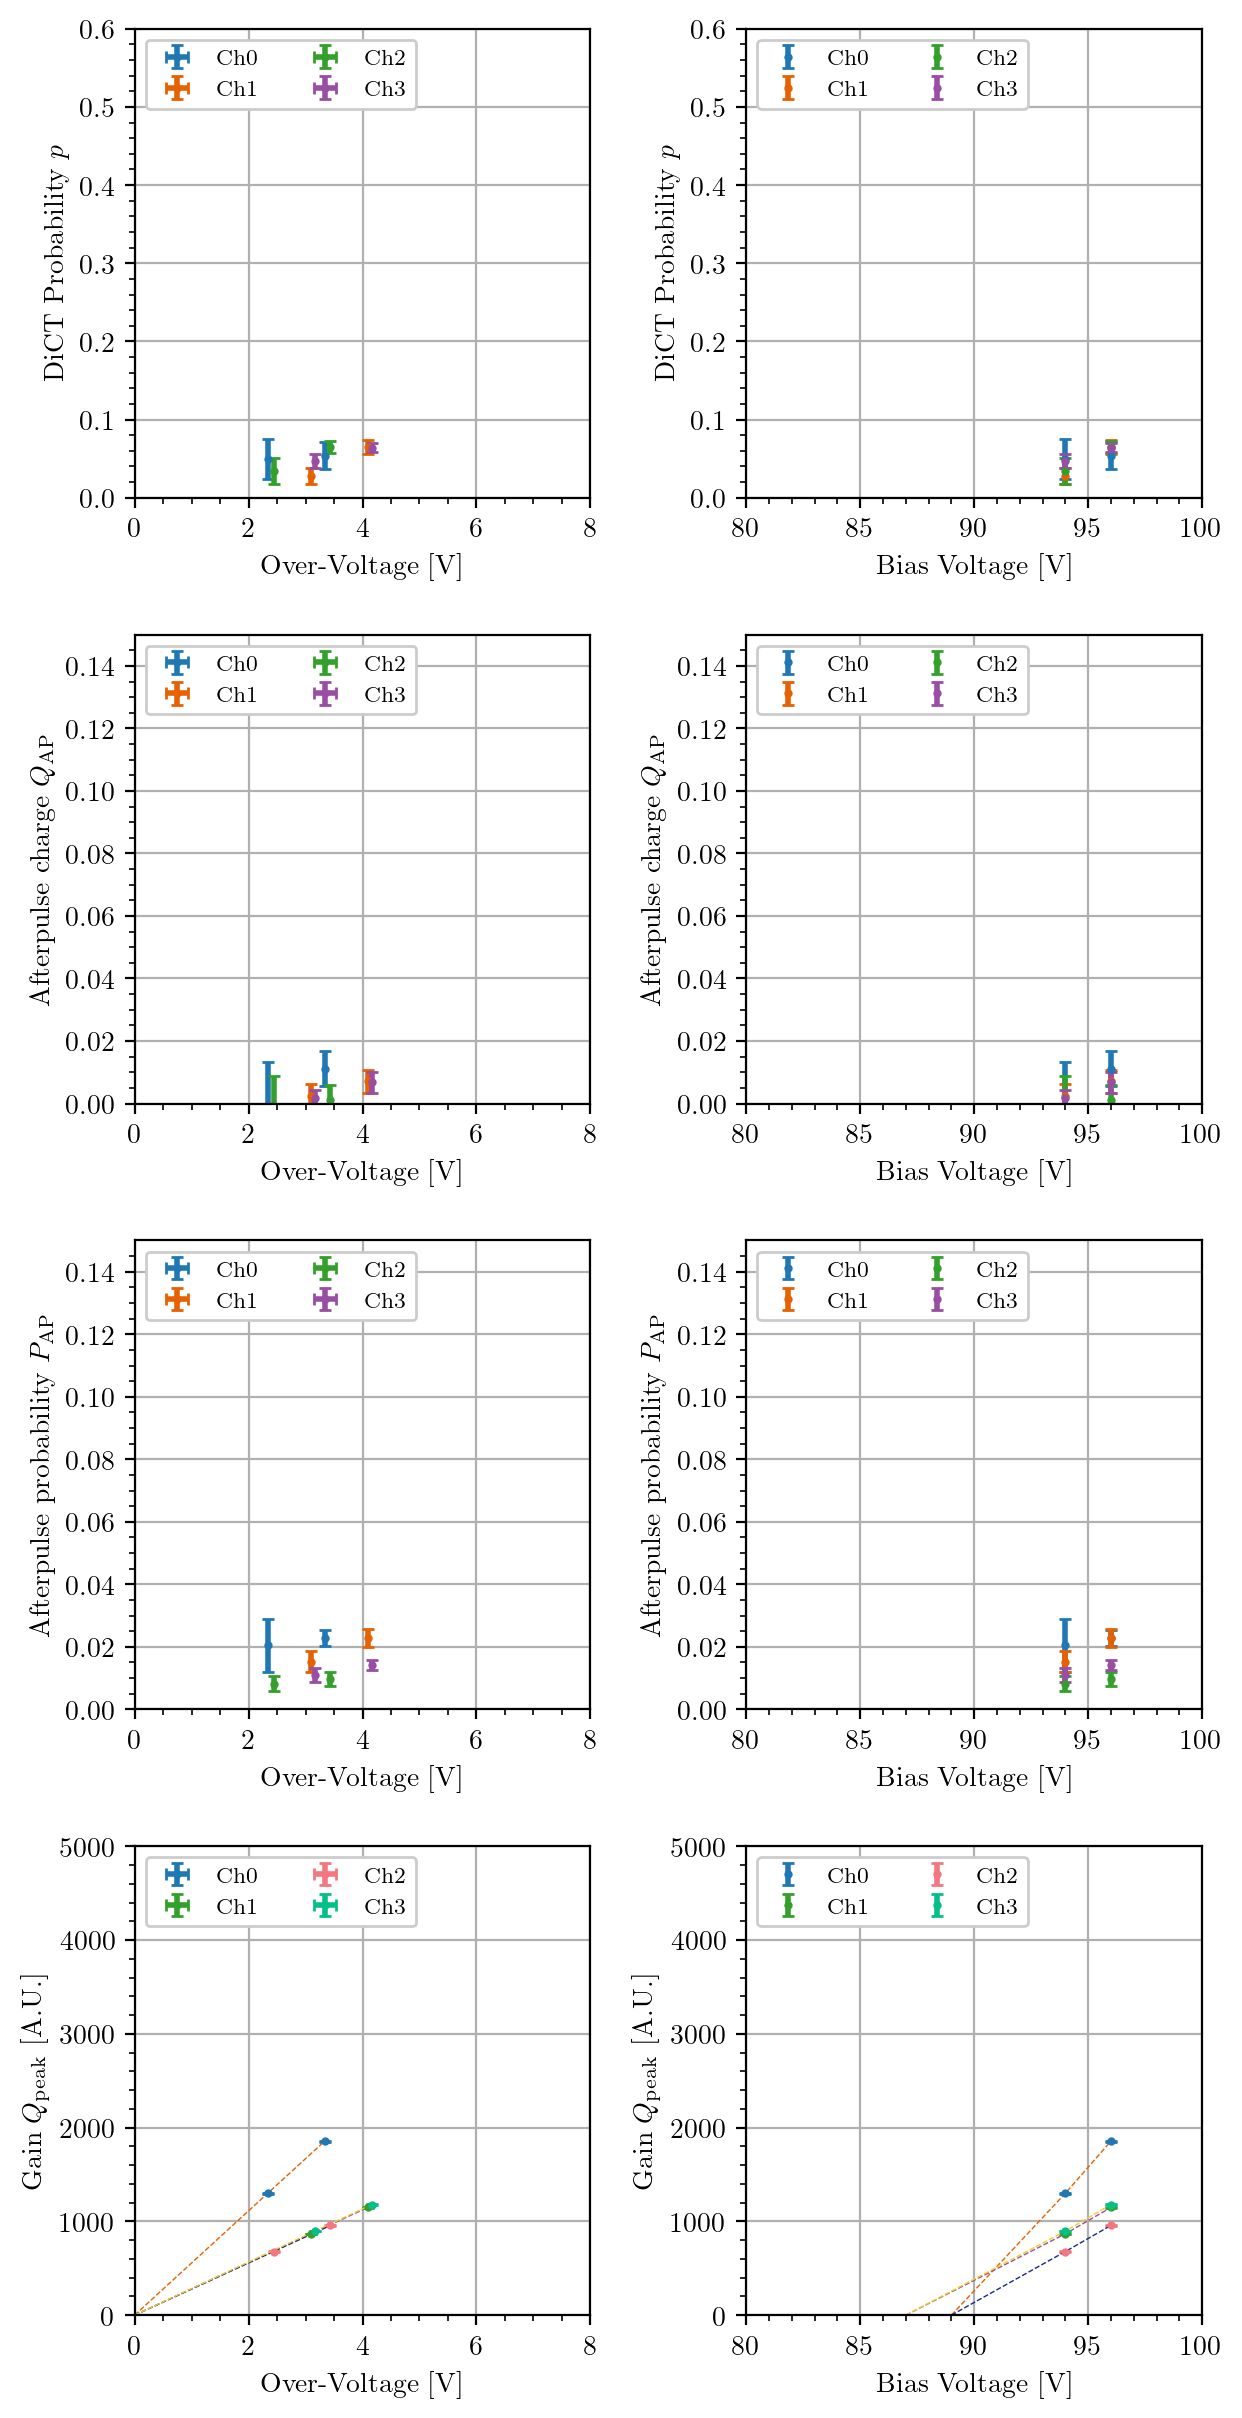

In [77]:
# Make summary plots
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

x_keys = ['ov','bias']
y_keys = ['dict','ap_charge', 'ap_prob', 'gain']
fig, axs = plt.subplots(len(y_keys),len(x_keys))
fig.set_size_inches(len(x_keys)*3, len(y_keys)*3)
fig.tight_layout(h_pad=3, w_pad=3)

for i,yk in enumerate(y_keys):
    for j,xk in enumerate(x_keys):
        for ch in channels:
            if xk=='ov':
                axs[i,j].errorbar(
                    results[yk][ch][xk],
                    results[yk][ch][yk],
                    xerr=results[yk][ch][f'{xk}_err'],
                    yerr=results[yk][ch][f'{yk}_err'],
                    label=f'Ch{ch}',
                    fmt='o',
                    markersize=2)
            elif xk=='bias':
                axs[i,j].errorbar(
                    results[yk][ch][xk],
                    results[yk][ch][yk],
                    yerr=results[yk][ch][f'{yk}_err'],
                    label=f'Ch{ch}',
                    fmt='o',
                    markersize=2)
            if yk=='gain':
                if xk=='ov':
                    axs[i,j].plot(
                        np.insert(results['gain'][ch]['ov'],0,0),
                        np.insert(results['gain'][ch]['ov']*vbd_fits[ch]['par'][0]*2,0,0),
                        '--',
                        linewidth=0.5)
                elif xk=='bias':
                    axs[i,j].plot(
                        np.insert(results['gain'][ch]['bias'],0,vbd_fits[ch]['vbd']),
                        np.insert((results['gain'][ch]['bias']-vbd_fits[ch]['vbd'])*vbd_fits[ch]['par'][0],0,0),
                        '--',
                        linewidth=0.5)
        axs[i,j].legend(ncol=2)
        if j==0:
            axs[i,j].set_xlabel(r'Over-Voltage [V]')
            axs[i,j].set_xlim(0, 8)
        else:
            axs[i,j].set_xlabel(r'Bias Voltage [V]')
            axs[i,j].set_xlim(80, 100)
        if i==0:
            axs[i,j].set_ylabel(r'DiCT Probability $p$')
            axs[i,j].set_ylim(0, 0.6)
        elif i==1:
            axs[i,j].set_ylabel(r'Afterpulse charge $Q_{\rm AP}$')
            axs[i,j].set_ylim(0, 0.15)
        elif i==2:
            axs[i,j].set_ylabel(r'Afterpulse probability $P_{\rm AP}$')
            axs[i,j].set_ylim(0, 0.15)
        elif i==3:
            axs[i,j].set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
            axs[i,j].set_ylim(0, 5e3)
        axs[i,j].grid()
        axs[i,j].minorticks_on()

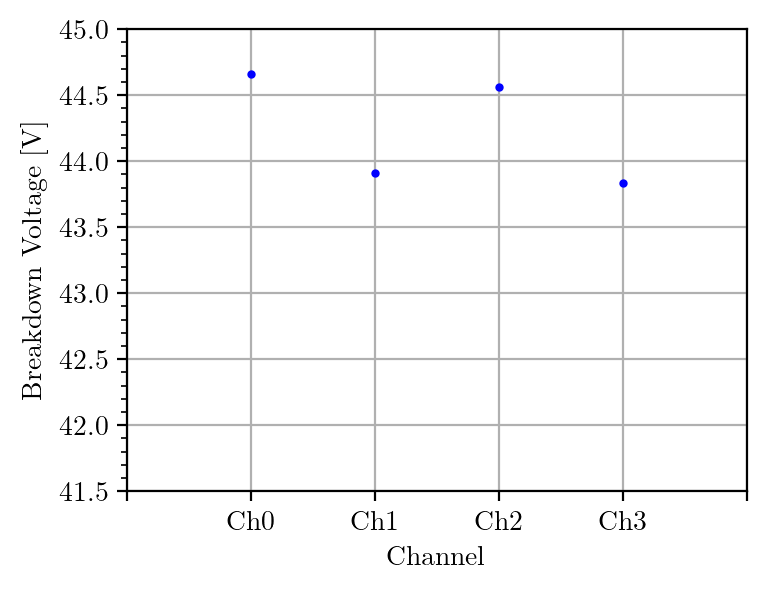

In [80]:
# Vbd-channel
fig, ax = plt.subplots()
channel_labels = []
for ch in channels:
    plt.errorbar(
        [ch], 
        [results['vbd'][ch]['vbd_sipm']],
        # yerr=[results['vbd'][ch]['vbd_sipm_err']],
        fmt='bo', markersize=2)
    channel_labels.append(f'Ch{ch}')
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage [V]')
ax.xaxis.set(ticks=np.arange(len(channels)), ticklabels=channel_labels)
plt.xlim(-1, 4)
plt.ylim(41.5, 45)
plt.grid()
plt.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.show()

In [81]:
# Analyze Vbd distribution
vbd_array = []
vbd_err_array = []
for ch in channels:
    vbd_array.append(results['vbd'][ch]['vbd_sipm'])
    vbd_err_array.append(results['vbd'][ch]['vbd_sipm_err'])
vbd_array = np.array(vbd_array)
vbd_err_array = np.array(vbd_err_array)
vbd_avg = np.average(vbd_array, weights=1/vbd_err_array**2)
vbd_stat = np.sum(vbd_err_array**(-2))**(-0.5)
print('Breakdown voltage per SiPM = {:.2f}+/-{:.2f}(stat) V'.format(vbd_avg, vbd_stat))
vbd_rms = np.std(vbd_array, ddof=1)
print('RMS variation = {:.2f}V'.format(vbd_rms))

ZeroDivisionError: Weights sum to zero, can't be normalized

# Write to HDF5 file

In [86]:
h5filename = f'data/calibration_liq4_2023-07-27.h5'
columns = ['channel', 'A1min', 'A1max', 'DiCT', 'DiCT_err', 'Qavg', 'Qavg_err', 'Qpeak', 'Qpeak_err', 'Qap', 'Qap_err', 'bsl_rms']
for volt in voltages:
    store = pd.HDFStore(h5filename)
    store.put(f'{volt}V',pd.DataFrame(np.array([[
        ch,
        amp_hist[ch][volt]['boundaries'][1],
        amp_hist[ch][volt]['boundaries'][2],
        crosstalk[ch][volt]['dict'],
        crosstalk[ch][volt]['dict_err'],
        gain_avg_fits[ch][volt]['Qavg'],
        gain_avg_fits[ch][volt]['Qavg_err'],
        gain_peak_fits[ch][volt]['Qpeak'],
        gain_peak_fits[ch][volt]['Qpeak_err'],
        ap_charge[ch][volt]['Qap'],
        ap_charge[ch][volt]['Qap_err'],
        mybsl[ch][volt]['rms_threshold']
    ] for ch in channels]), columns=columns).astype({'channel':'int'}))
    store.close()

In [88]:
store.close()

In [92]:
store = pd.HDFStore(h5filename)
store.keys()

['/94V', '/96V']

In [89]:
for volt in voltages:
    summary = pd.read_hdf('data/calibration_liq4_2023-07-27.h5', key=f'{volt}V')
    print(f'{volt}V')
    print(summary)

ValueError: The file 'data/calibration_liq4_2023-07-27.h5' is already opened, but not in read-only mode (as requested).

## Calculate rENF versus bias/over-voltage

Following https://ieeexplore.ieee.org/document/5402300 closely, the reduced excess noise factor (rENF) here is defined as
$$\mathrm{rENF}(V_{\rm bias})=\frac{1+p_{\rm DiCT}(V_{\rm bias})}{\mu(V_{\rm bias})/\mu(63V)},$$
where $p_{\rm DiCT}$ is the DiCT probability, and $\mu$ is the parameter obtained from the Vinogradov fits.
Since the laser intensity did not change when taking data at different voltages, $\mu$ is the relative PDE. We choose $V_{\rm bias}=63V$ as the reference point.


In [ ]:
results['renf'] = {}
for intn in intensities:
    results['renf'][intn] = {}
    for ch in channels:
        results['renf'][intn][ch] = {}
        results['renf'][intn][ch]['bias'] = np.array(voltages)
        results['renf'][intn][ch]['ov'] = results['renf'][intn][ch]['bias']/nsipms-results['vbd'][intn][ch]['vbd_sipm']
        results['renf'][intn][ch]['ov_err'] = np.ones(results['renf'][intn][ch]['ov'].shape[0])*results['vbd'][intn][ch]['vbd_sipm_err']
        results['renf'][intn][ch]['renf'] = np.array([(1+crosstalk[intn][ch][volt]['par'][1])/(crosstalk[intn][ch][volt]['par'][0]/crosstalk[intn][ch][voltages[0]]['par'][0]) for volt in voltages])
        results['renf'][intn][ch]['renf_err'] = results['renf'][intn][ch]['renf']*np.array([ ( crosstalk[intn][ch][volt]['cov'][0,0]/(crosstalk[intn][ch][volt]['par'][0])**2 + crosstalk[intn][ch][volt]['cov'][1,1]/(1+crosstalk[intn][ch][volt]['par'][1])**2 )**0.5 for volt in voltages])


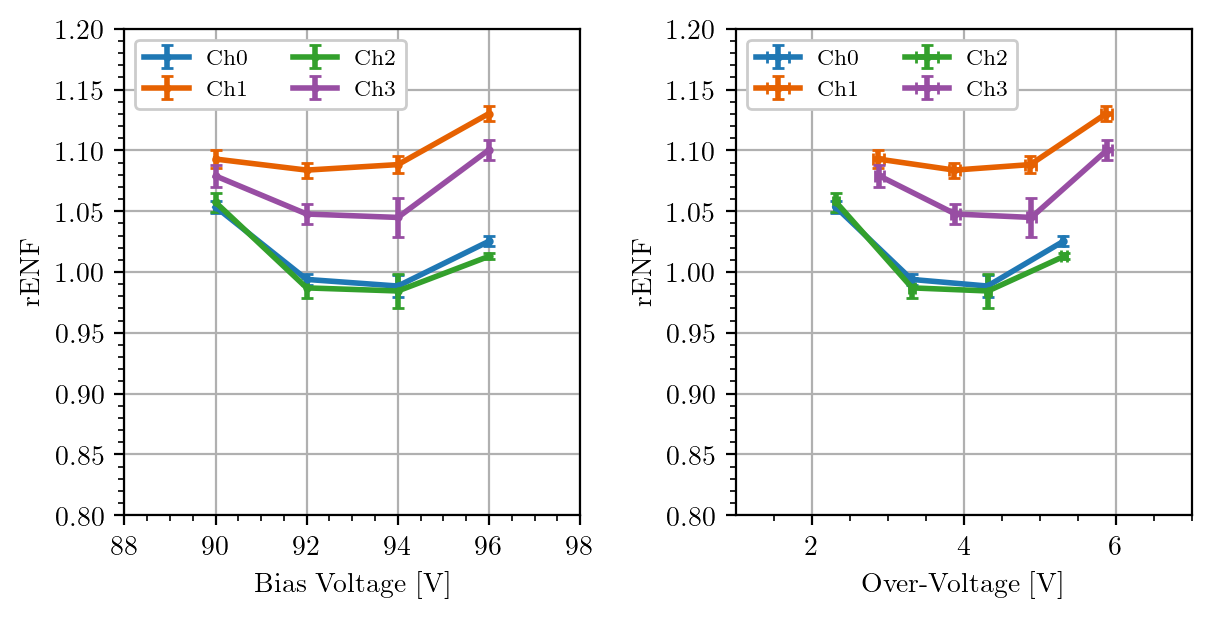

In [ ]:
# Relative PDE: the mu parameter from the DiCT fits
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 3)
fig.tight_layout(h_pad=3, w_pad=3)
intn = 1070
for ch in channels:
    axs[0].errorbar(
        results['renf'][intn][ch]['bias'],
        results['renf'][intn][ch]['renf'],
        yerr=results['renf'][intn][ch]['renf_err'],
        label=f'Ch{ch}',
        fmt='C{}o-'.format(ch),
        markersize=2)
    axs[1].errorbar(
        results['renf'][intn][ch]['ov'],
        results['renf'][intn][ch]['renf'],
        xerr=results['renf'][intn][ch]['ov_err'],
        yerr=results['renf'][intn][ch]['renf_err'],
        label=f'Ch{ch}',
        fmt='C{}o-'.format(ch),
        markersize=2)
for i in [0,1]:
    if i==0:
        axs[i].set_xlabel('Bias Voltage [V]')
        axs[i].set_xlim(88, 98)
    else:
        axs[i].set_xlabel('Over-Voltage [V]')
        axs[i].set_xlim(1, 7)

    axs[i].set_ylabel('rENF')
    axs[i].legend(ncol=2)
    axs[i].grid()
    axs[i].minorticks_on()
    axs[i].set_ylim(0.8,1.20)
    